# An Analysis of Wind Speeds in the North Sea

---

### Data

We will be working with [data](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/) collected by [DWD](https://dwd.de) on Helgoland in a 10-minute intervall from 1996 to 2022. For loading the data, we have to manually collect the from a http server.


### Imports and Usage

You can simply use the `environment.yml` file to create a new conda environment with all the needed packages by running `conda env create -f environment.yml`. The only relevant parameter you may want to change is `RELOAD`. If set to `True`, all the needed data will be downloaded and saved in the `data/` folder.

## Data Loading

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import requests as rq
import zipfile
from bs4 import BeautifulSoup
import os
import seaborn as sns
import pickle

plt.rcParams['figure.dpi'] = 400

# set true to download the data and unzip into the current directory
RELOAD = False
ZIP_NAME = "data.zip"
DATA_FOLDER = "data"

DATA_BASE_URL = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/"
KINDS = ["wind", "air_temperature", "precipitation", "solar"]
METRIC_URLS = [DATA_BASE_URL + postfix + "/historical/" for postfix in KINDS]
print(METRIC_URLS)

['https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/wind/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/air_temperature/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/precipitation/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/solar/historical/']


In [2]:
def download_and_extract(url: str, kind: str, station_id: str = "02115") -> dict:
    response = rq.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    # find dataset desciption (pdf)
    descr_resp = rq.get(f"{DATA_BASE_URL}/{kind}")
    descr_soup = BeautifulSoup(descr_resp.text, "html.parser")
    descriptions = [a.get("href") for a in descr_soup.find_all("a", href=True) if a.get("href").__contains__("pdf")]
    descrs_resps = list(map(lambda desc: rq.get(f"{DATA_BASE_URL}/{kind}/{desc}"), descriptions))

    # Extract all links with data of the appropiate station
    links = [a.get("href") for a in soup.find_all('a', href=True) if a.get("href").__contains__(station_id)]
    print(f"Found links: {links}")

    responses = [rq.get(url + file) for file in links]

    # check if we need to create folders
    save_path = os.path.join("data", kind)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # save dataset description pdfs
    for descr, resp in zip(descriptions, descrs_resps):
        with open(os.path.join(save_path, descr), "wb") as file:
            file.write(resp.content)

    # for each matching response download the zip and extract it
    files = [] # remember file names of the extracted zip files
    for i, r in enumerate(responses):
        zip_name = os.path.join("data", kind, f"file{i}.zip")
        with open(zip_name, "wb") as z:
            z.write(r.content)

        with zipfile.ZipFile(zip_name, "r") as zip_file:
            for filename in zip_file.namelist():
                files.append(os.path.join(save_path, filename))
            zip_file.extractall(os.path.join("data", kind))

        # we don't need the zip anymore
        os.remove(zip_name)
    
    return files

# have mapping of metric to relevant files for loading into dataframes later on
kind_files = { kind : [] for kind in KINDS }
kind_file_paths = os.path.join("data", "contents.pickle")
if RELOAD:
    for kind, folder in zip(KINDS, METRIC_URLS):
        print(f"{kind}: {folder}")
        files = download_and_extract(folder, kind)
        kind_files[kind] = files

    with open(os.path.join(kind_file_paths), 'wb') as handle:
        pickle.dump(kind_files, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else:
    with open(kind_file_paths, 'rb') as handle:
        kind_files = pickle.load(handle)

for kind in KINDS:
    print(f"Files containing {kind} data:\n\t{kind_files[kind]}")

wind: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/wind/historical/
Found links: ['10minutenwerte_wind_02115_19961220_19991231_hist.zip', '10minutenwerte_wind_02115_20000101_20091231_hist.zip', '10minutenwerte_wind_02115_20100101_20191231_hist.zip', '10minutenwerte_wind_02115_20200101_20221231_hist.zip']
air_temperature: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/air_temperature/historical/
Found links: ['10minutenwerte_TU_02115_19961219_19991231_hist.zip', '10minutenwerte_TU_02115_20000101_20091231_hist.zip', '10minutenwerte_TU_02115_20100101_20191231_hist.zip', '10minutenwerte_TU_02115_20200101_20221231_hist.zip']
precipitation: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/precipitation/historical/
Found links: ['10minutenwerte_nieder_02115_19961219_19991231_hist.zip', '10minutenwerte_nieder_02115_20000101_20091231_hist.zip', '10minutenwerte_nieder_02115_

In [3]:
kind_df = { kind: None for kind in KINDS }
for kind, files in kind_files.items():
    dfs = []
    for file in files:
        df = pd.read_csv(file, sep=";")
        df["MESS_DATUM"] = pd.to_datetime(df["MESS_DATUM"], format="%Y%m%d%H%M")
        dfs.append(df)
    df = pd.concat(dfs)
    df.sort_values(by="MESS_DATUM", inplace=True)
    df.columns = map(lambda c: c if c == "STATIONS_ID" or c == "MESS_DATUM" else f"{c}_{kind}", df.columns)
    print(f"{kind}:\n{df.describe()}")
    kind_df[kind] = df

wind:
       STATIONS_ID                     MESS_DATUM       QN_wind    FF_10_wind  \
count    1348857.0                        1348857  1.348857e+06  1.348857e+06   
mean        2115.0  2010-02-09 21:28:30.455297280  2.267581e+00 -3.537724e+01   
min         2115.0            1996-12-19 10:40:00  1.000000e+00 -9.990000e+02   
25%         2115.0            2003-09-13 20:10:00  1.000000e+00  4.800000e+00   
50%         2115.0            2010-02-13 02:20:00  3.000000e+00  7.400000e+00   
75%         2115.0            2016-07-12 20:40:00  3.000000e+00  1.030000e+01   
max         2115.0            2022-12-31 23:50:00  3.000000e+00  5.180000e+01   
std            0.0                            NaN  9.586172e-01  2.046541e+02   

         DD_10_wind  
count  1.348857e+06  
mean   1.529980e+02  
min   -9.990000e+02  
25%    1.200000e+02  
50%    2.100000e+02  
75%    2.800000e+02  
max    3.600000e+02  
std    2.606936e+02  
air_temperature:
       STATIONS_ID                     MESS_DATUM

In [4]:
dfs = list(kind_df.values())
df = pd.merge(dfs[0], dfs[1], on=["MESS_DATUM", "STATIONS_ID"], how="inner", suffixes=tuple(list(map(lambda x: "_" + x, kind_df.keys()))[:2]))

# Loop through the remaining DataFrames and merge with the result
for i, df1 in enumerate(dfs[2:]):
    df = pd.merge(df, df1, on=["MESS_DATUM", "STATIONS_ID"], how="inner", suffixes=(None, "_" + list(kind_df.keys())[i+2]))

# Display the result
df

STATIONS_ID          MESS_DATUM    QN_wind  FF_10_wind  DD_10_wind  \
0               2115 1996-12-19 10:40:00          1        15.8          70   
1               2115 1996-12-19 10:50:00          1        16.2          70   
2               2115 1996-12-19 11:00:00          1        16.6          70   
3               2115 1996-12-19 11:10:00          1        16.0          80   
4               2115 1996-12-19 11:20:00          1        16.3          70   
...              ...                 ...        ...         ...         ...   
1348936         2115 2022-12-31 23:10:00          3        13.6         230   
1348937         2115 2022-12-31 23:20:00          3        12.4         230   
1348938         2115 2022-12-31 23:30:00          3        12.6         230   
1348939         2115 2022-12-31 23:40:00          3        12.6         230   
1348940         2115 2022-12-31 23:50:00          3        12.9         230   

        eor_wind  QN_air_temperature  PP_10_air_temperature  \
0            eor                 1.0                 1008.2   
1            eor                 1.0                 1008.1   
2            eor                 1.0                 1008.1   
3            eor                 1.0                 1008.1   
4            eor                 1.0                 1008.0   
...          ...                 ...                    ...   
1348936      eor                 NaN                 1000.6   
1348937      eor                 NaN                 1000.6   
1348938      eor                 NaN                 1000.5   
1348939      eor                 NaN                 1000.6   
1348940      eor                 NaN                 1000.7   

         TT_10_air_temperature  TM5_10_air_temperature  ...  \
0                          2.0                     1.9  ...   
1                          2.0                     1.9  ...   
2                          2.1                     2.1  ...   
3                          2.3                     2.2  ...   
4                          2.1                     2.0  ...   
...                        ...                     ...  ...   
1348936                   11.1                    10.3  ...   
1348937                   10.9                    10.2  ...   
1348938                   11.1                    10.3  ...   
1348939                   11.2                    10.4  ...   
1348940                   11.2                    10.4  ...   

         RWS_IND_10_precipitation    QN_precipitation  eor_precipitation  \
0                               0                 NaN                NaN   
1                               0                 NaN                NaN   
2                               0                 NaN                NaN   
3                               0                 NaN                NaN   
4                               0                 NaN                NaN   
...                           ...                 ...                ...   
1348936                         0                 3.0                eor   
1348937                         0                 3.0                eor   
1348938                         0                 3.0                eor   
1348939                         0                 3.0                eor   
1348940                         0                 3.0                eor   

        QN_solar  DS_10_solar  GS_10_solar  SD_10_solar  LS_10_solar  \
0            1.0       -999.0       -999.0          0.0         -999   
1            1.0       -999.0       -999.0          0.0         -999   
2            1.0       -999.0       -999.0          0.0         -999   
3            1.0       -999.0       -999.0          0.0         -999   
4            1.0       -999.0       -999.0          0.0         -999   
...          ...          ...          ...          ...          ...   
1348936      NaN          0.0          0.0          0.0         -999   
1348937      NaN          0.0          0.0          0.0  

## Explorative Data Analysis

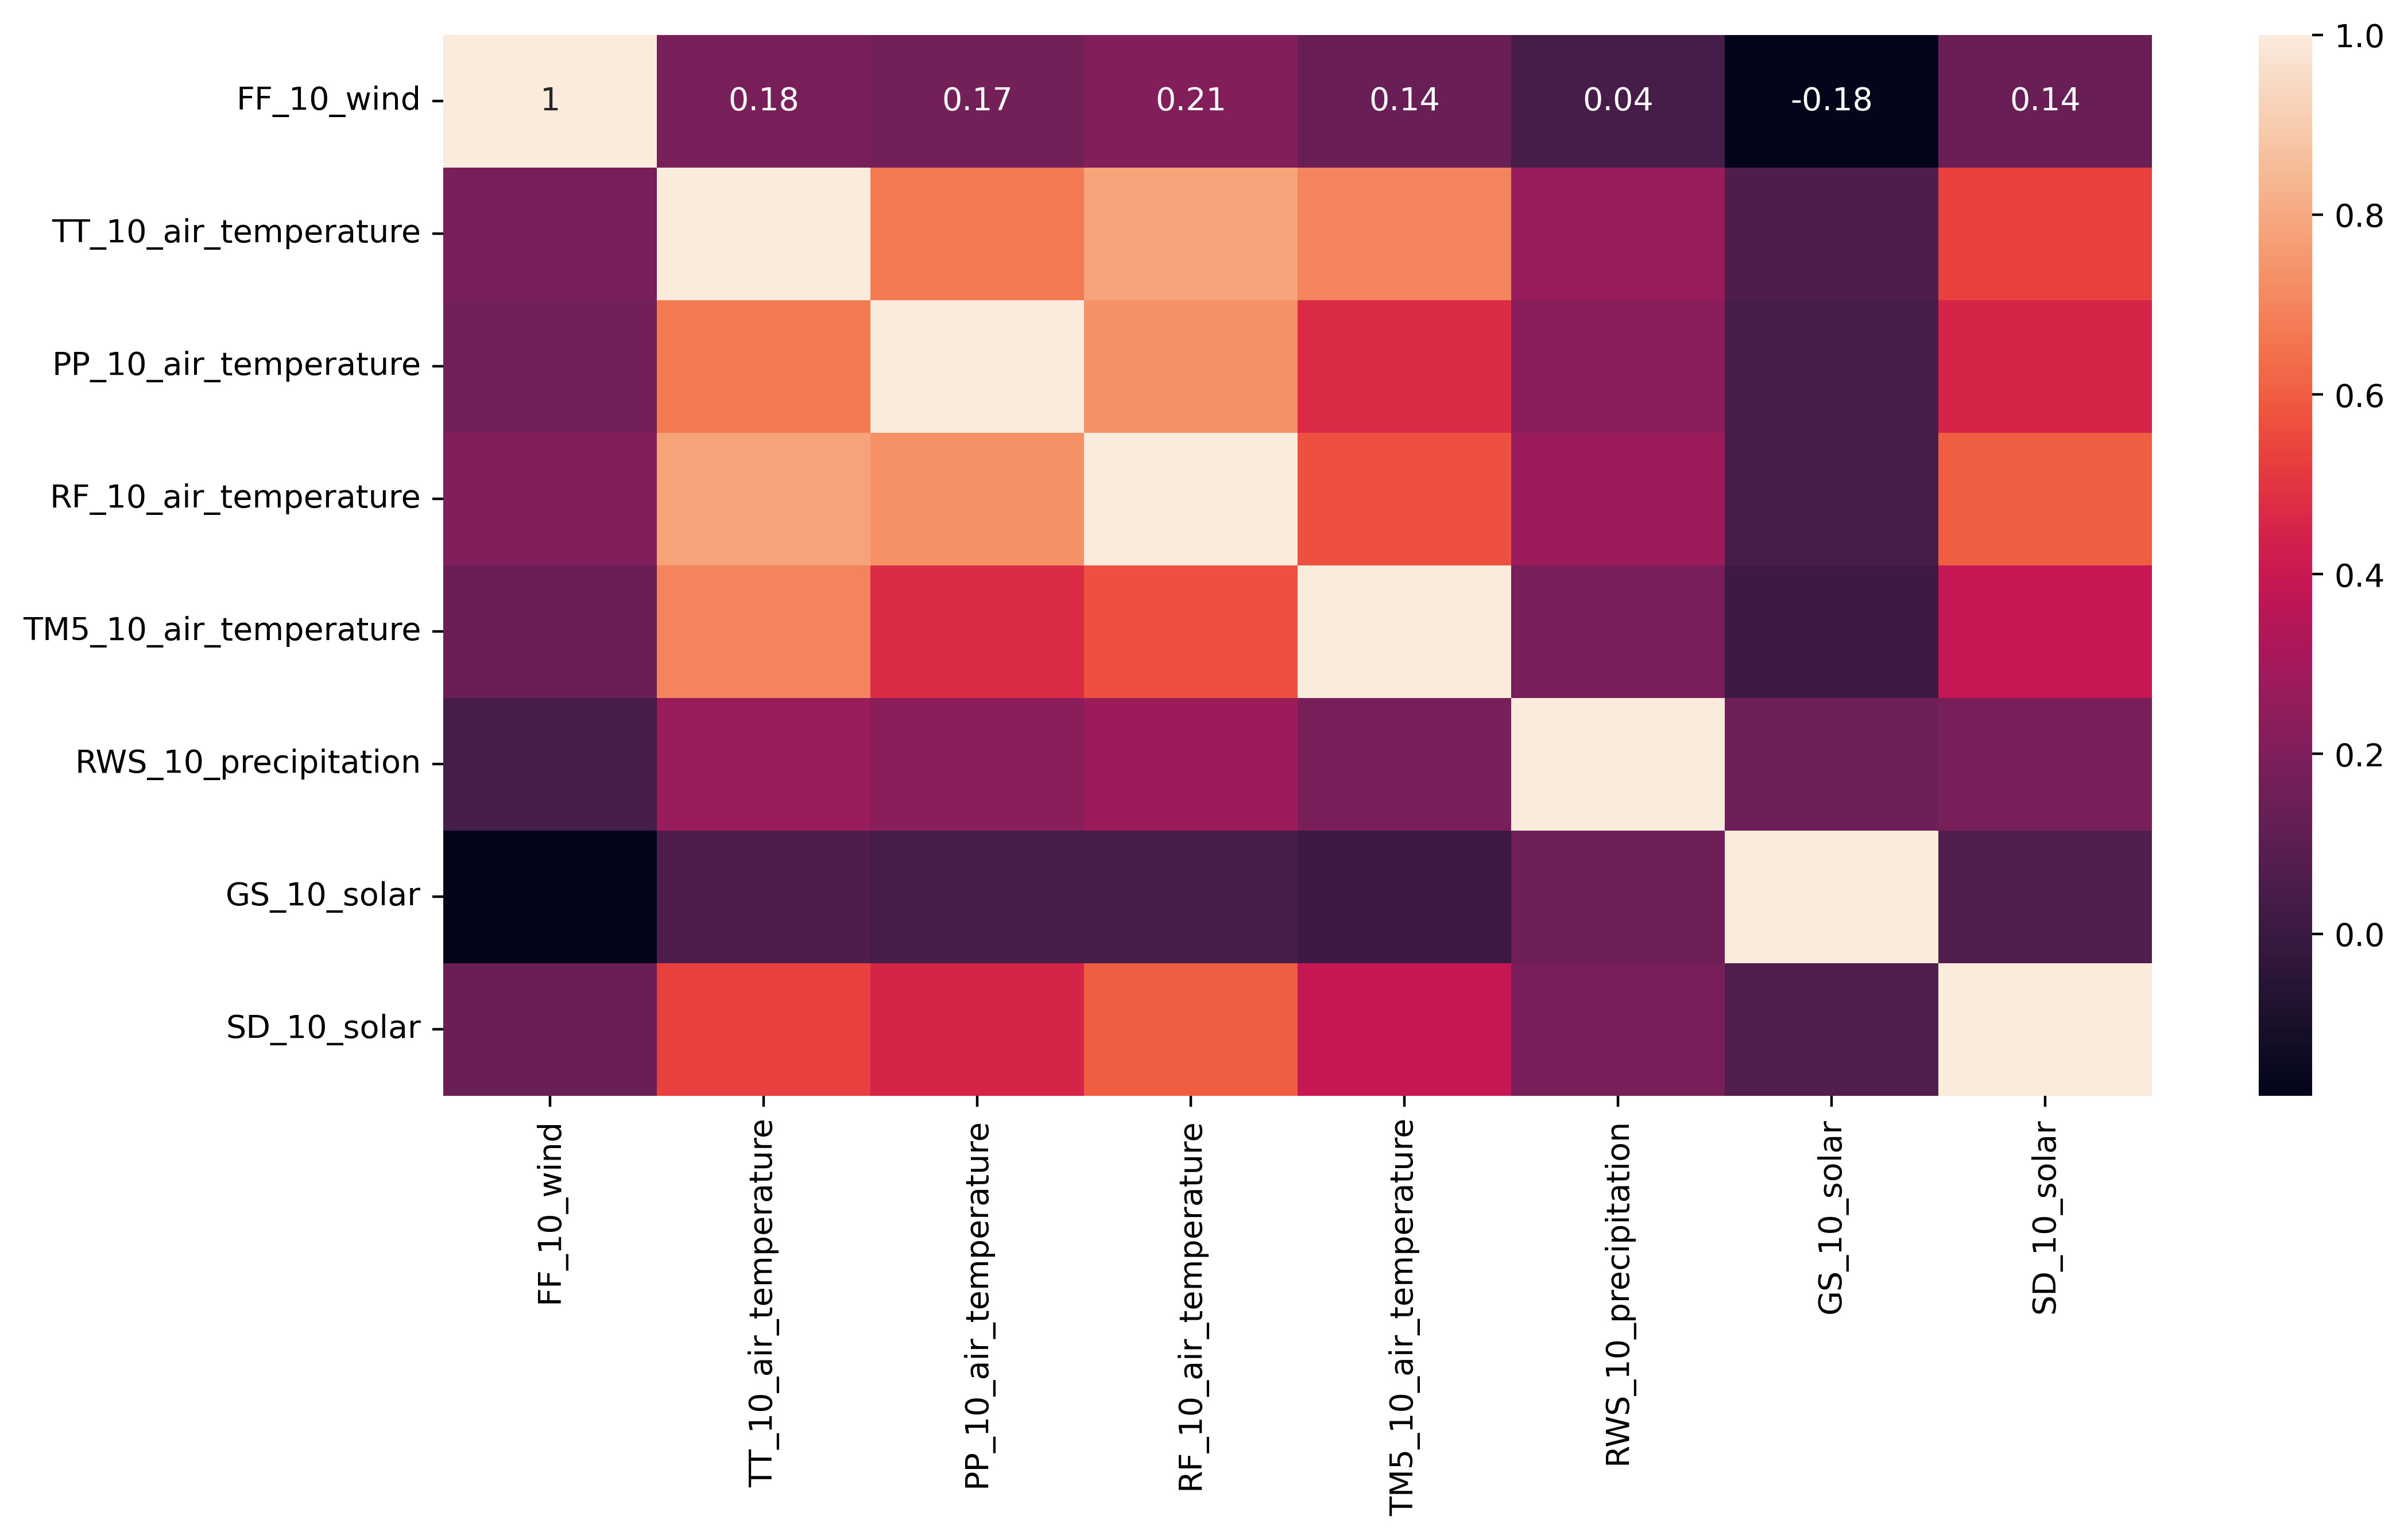

In [320]:
_ = plt.figure(figsize=(12, 6))
corr = df[["FF_10_wind", "TT_10_air_temperature", "PP_10_air_temperature", "RF_10_air_temperature", "TM5_10_air_temperature", "RWS_10_precipitation", "GS_10_solar", "SD_10_solar"]].corr().round(2)
sns.heatmap(corr, annot=True)
plt.show()

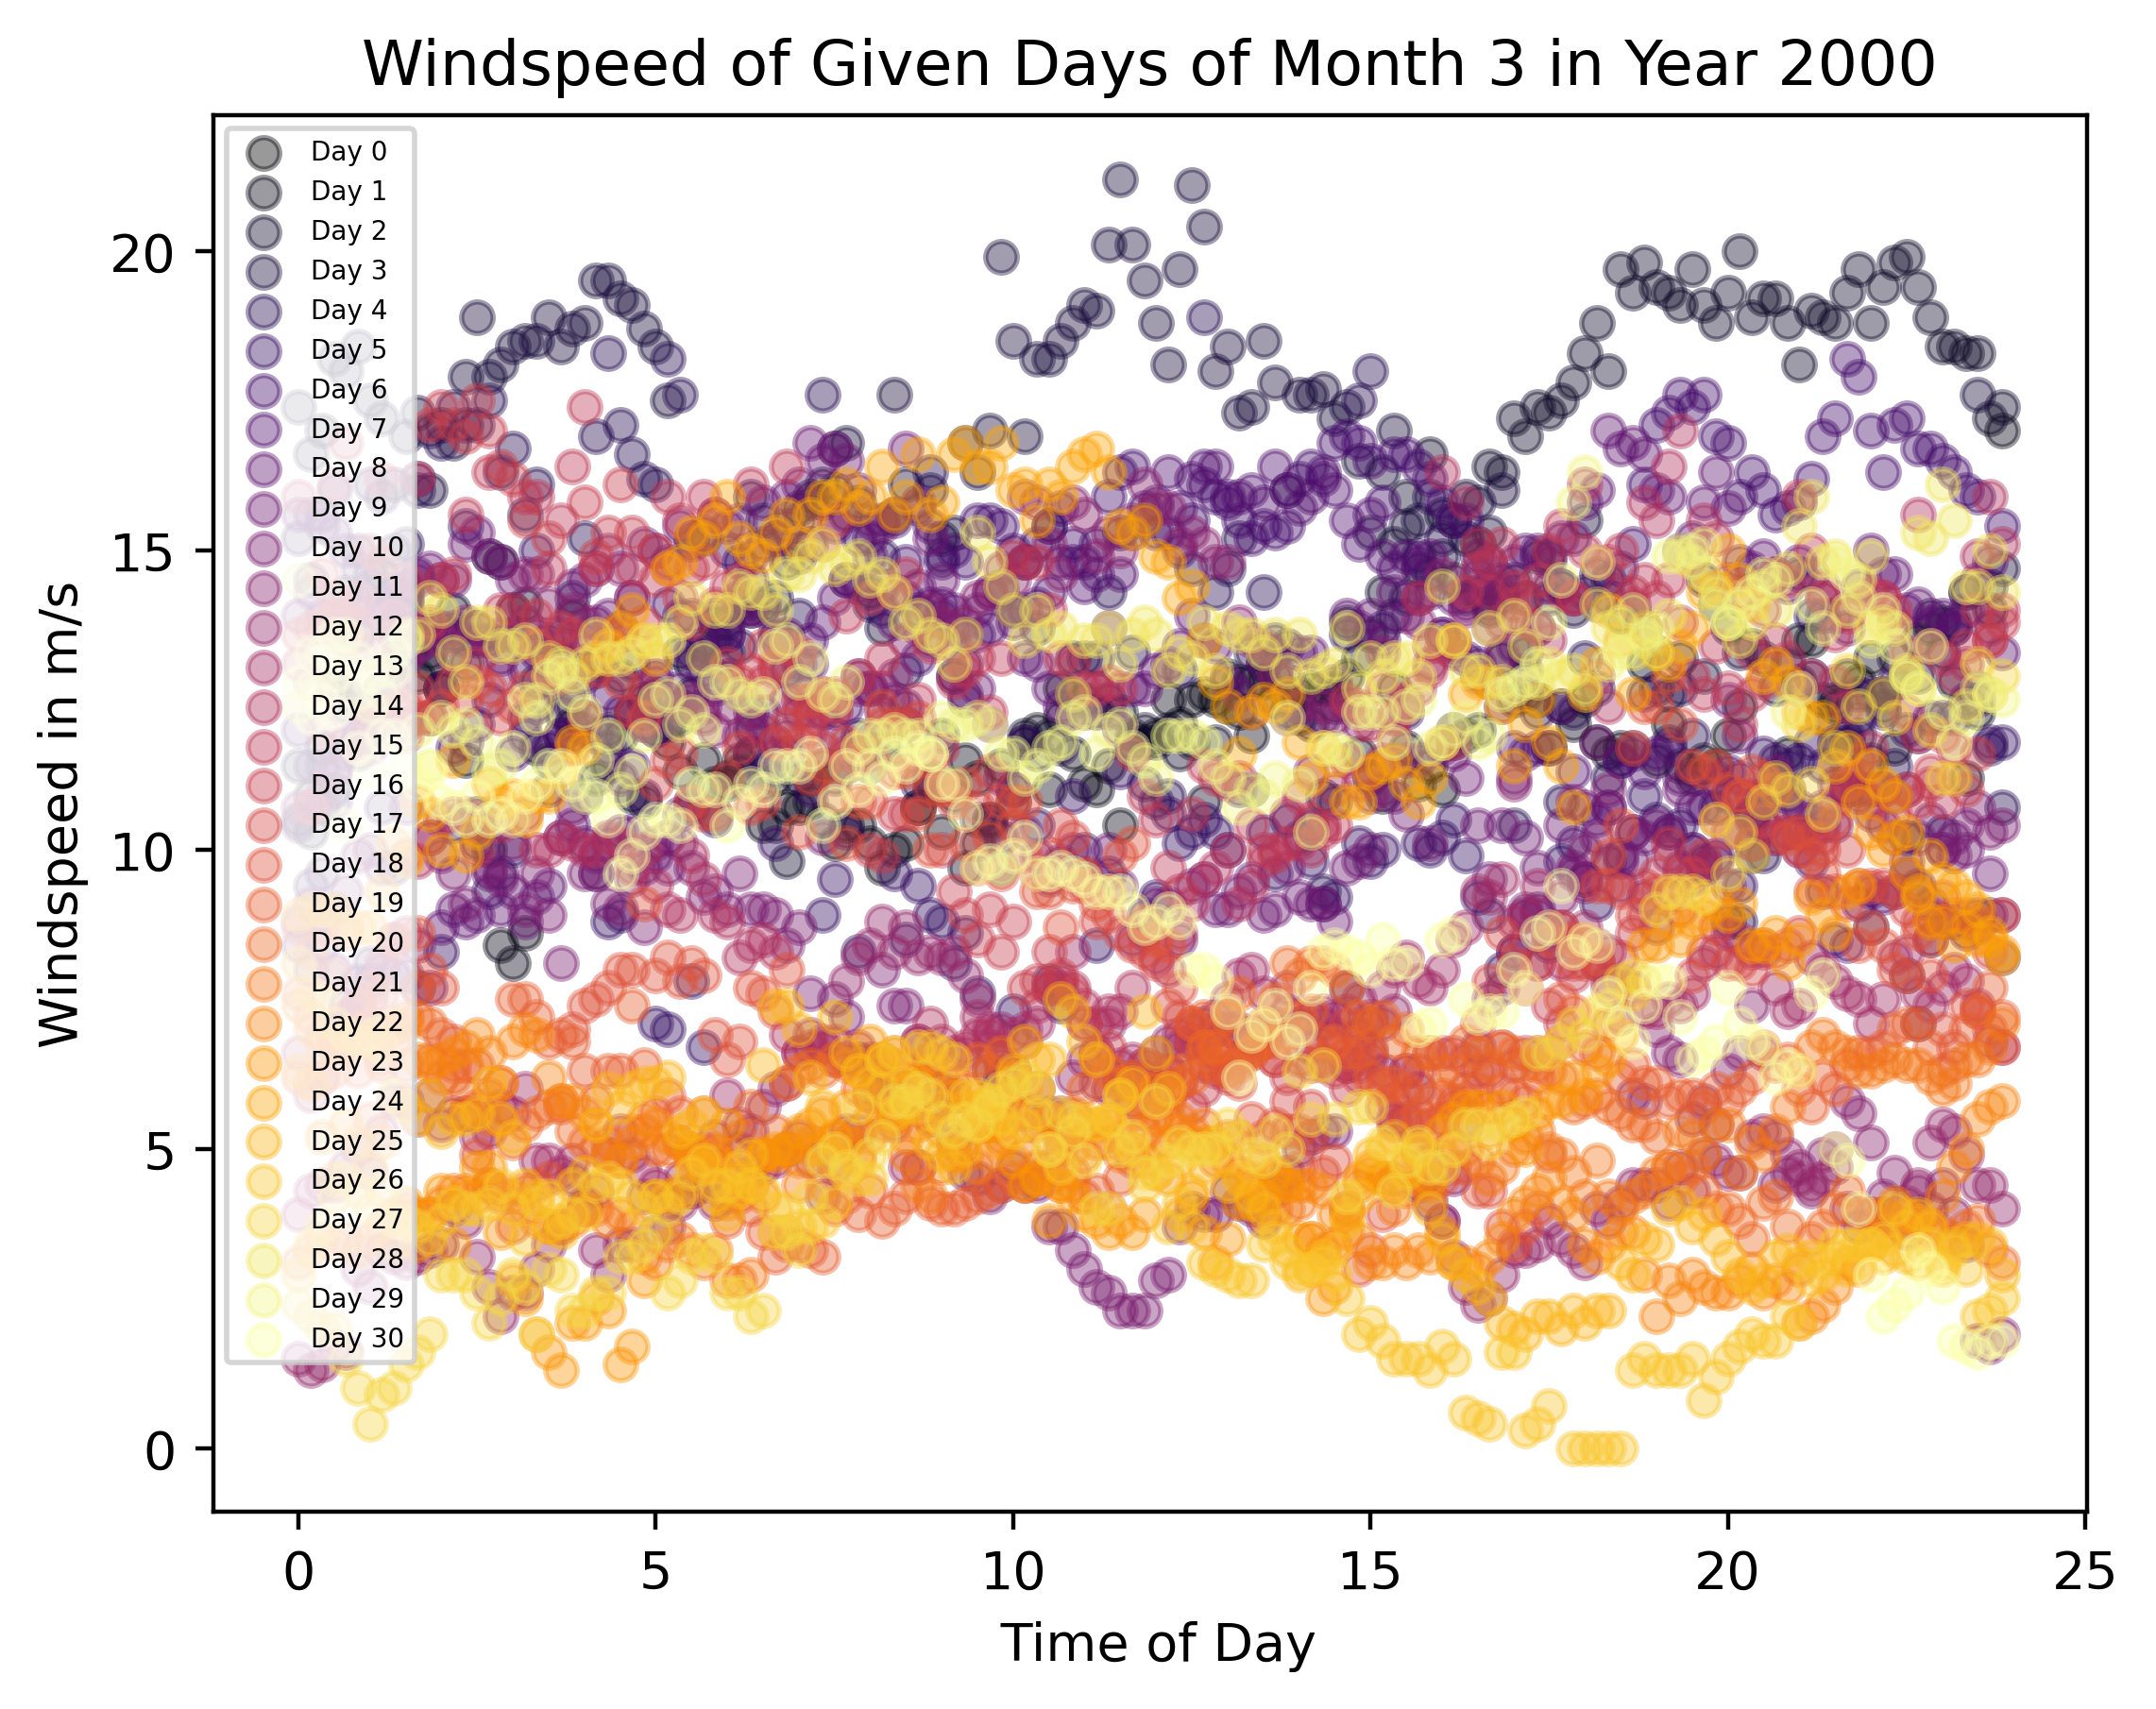

In [326]:
# Parameters for the plot shown: day, month, year
#d=1
m=3
y=2000
colors = plt.cm.inferno(np.linspace(0,1,31))
wind = kind_df["wind"]
for d in range(0,31):
    wind['FF_10_wind'] = wind['FF_10_wind'].replace(-999, float('nan'))
    mask = (wind['MESS_DATUM'].dt.day == d) & (wind['MESS_DATUM'].dt.month == m) & (wind['MESS_DATUM'].dt.year == y)
    plt.scatter( wind[mask]["MESS_DATUM"].dt.hour + (wind[mask]["MESS_DATUM"].dt.minute)*1/60, wind[mask]["FF_10_wind"] , color=colors[d], alpha=0.4, label=f'Day {d}')
# wind[mask]["MESS_DATUM"].dt.hour + (wind[mask]["MESS_DATUM"].dt.minute)*1/60 make this better...
plt.ylabel("Windspeed in m/s")
plt.xlabel(" Time of Day")
plt.title(f'Windspeed of Given Days of Month {m} in Year {y}')
plt.legend(loc='best', fontsize='5')
plt.show()

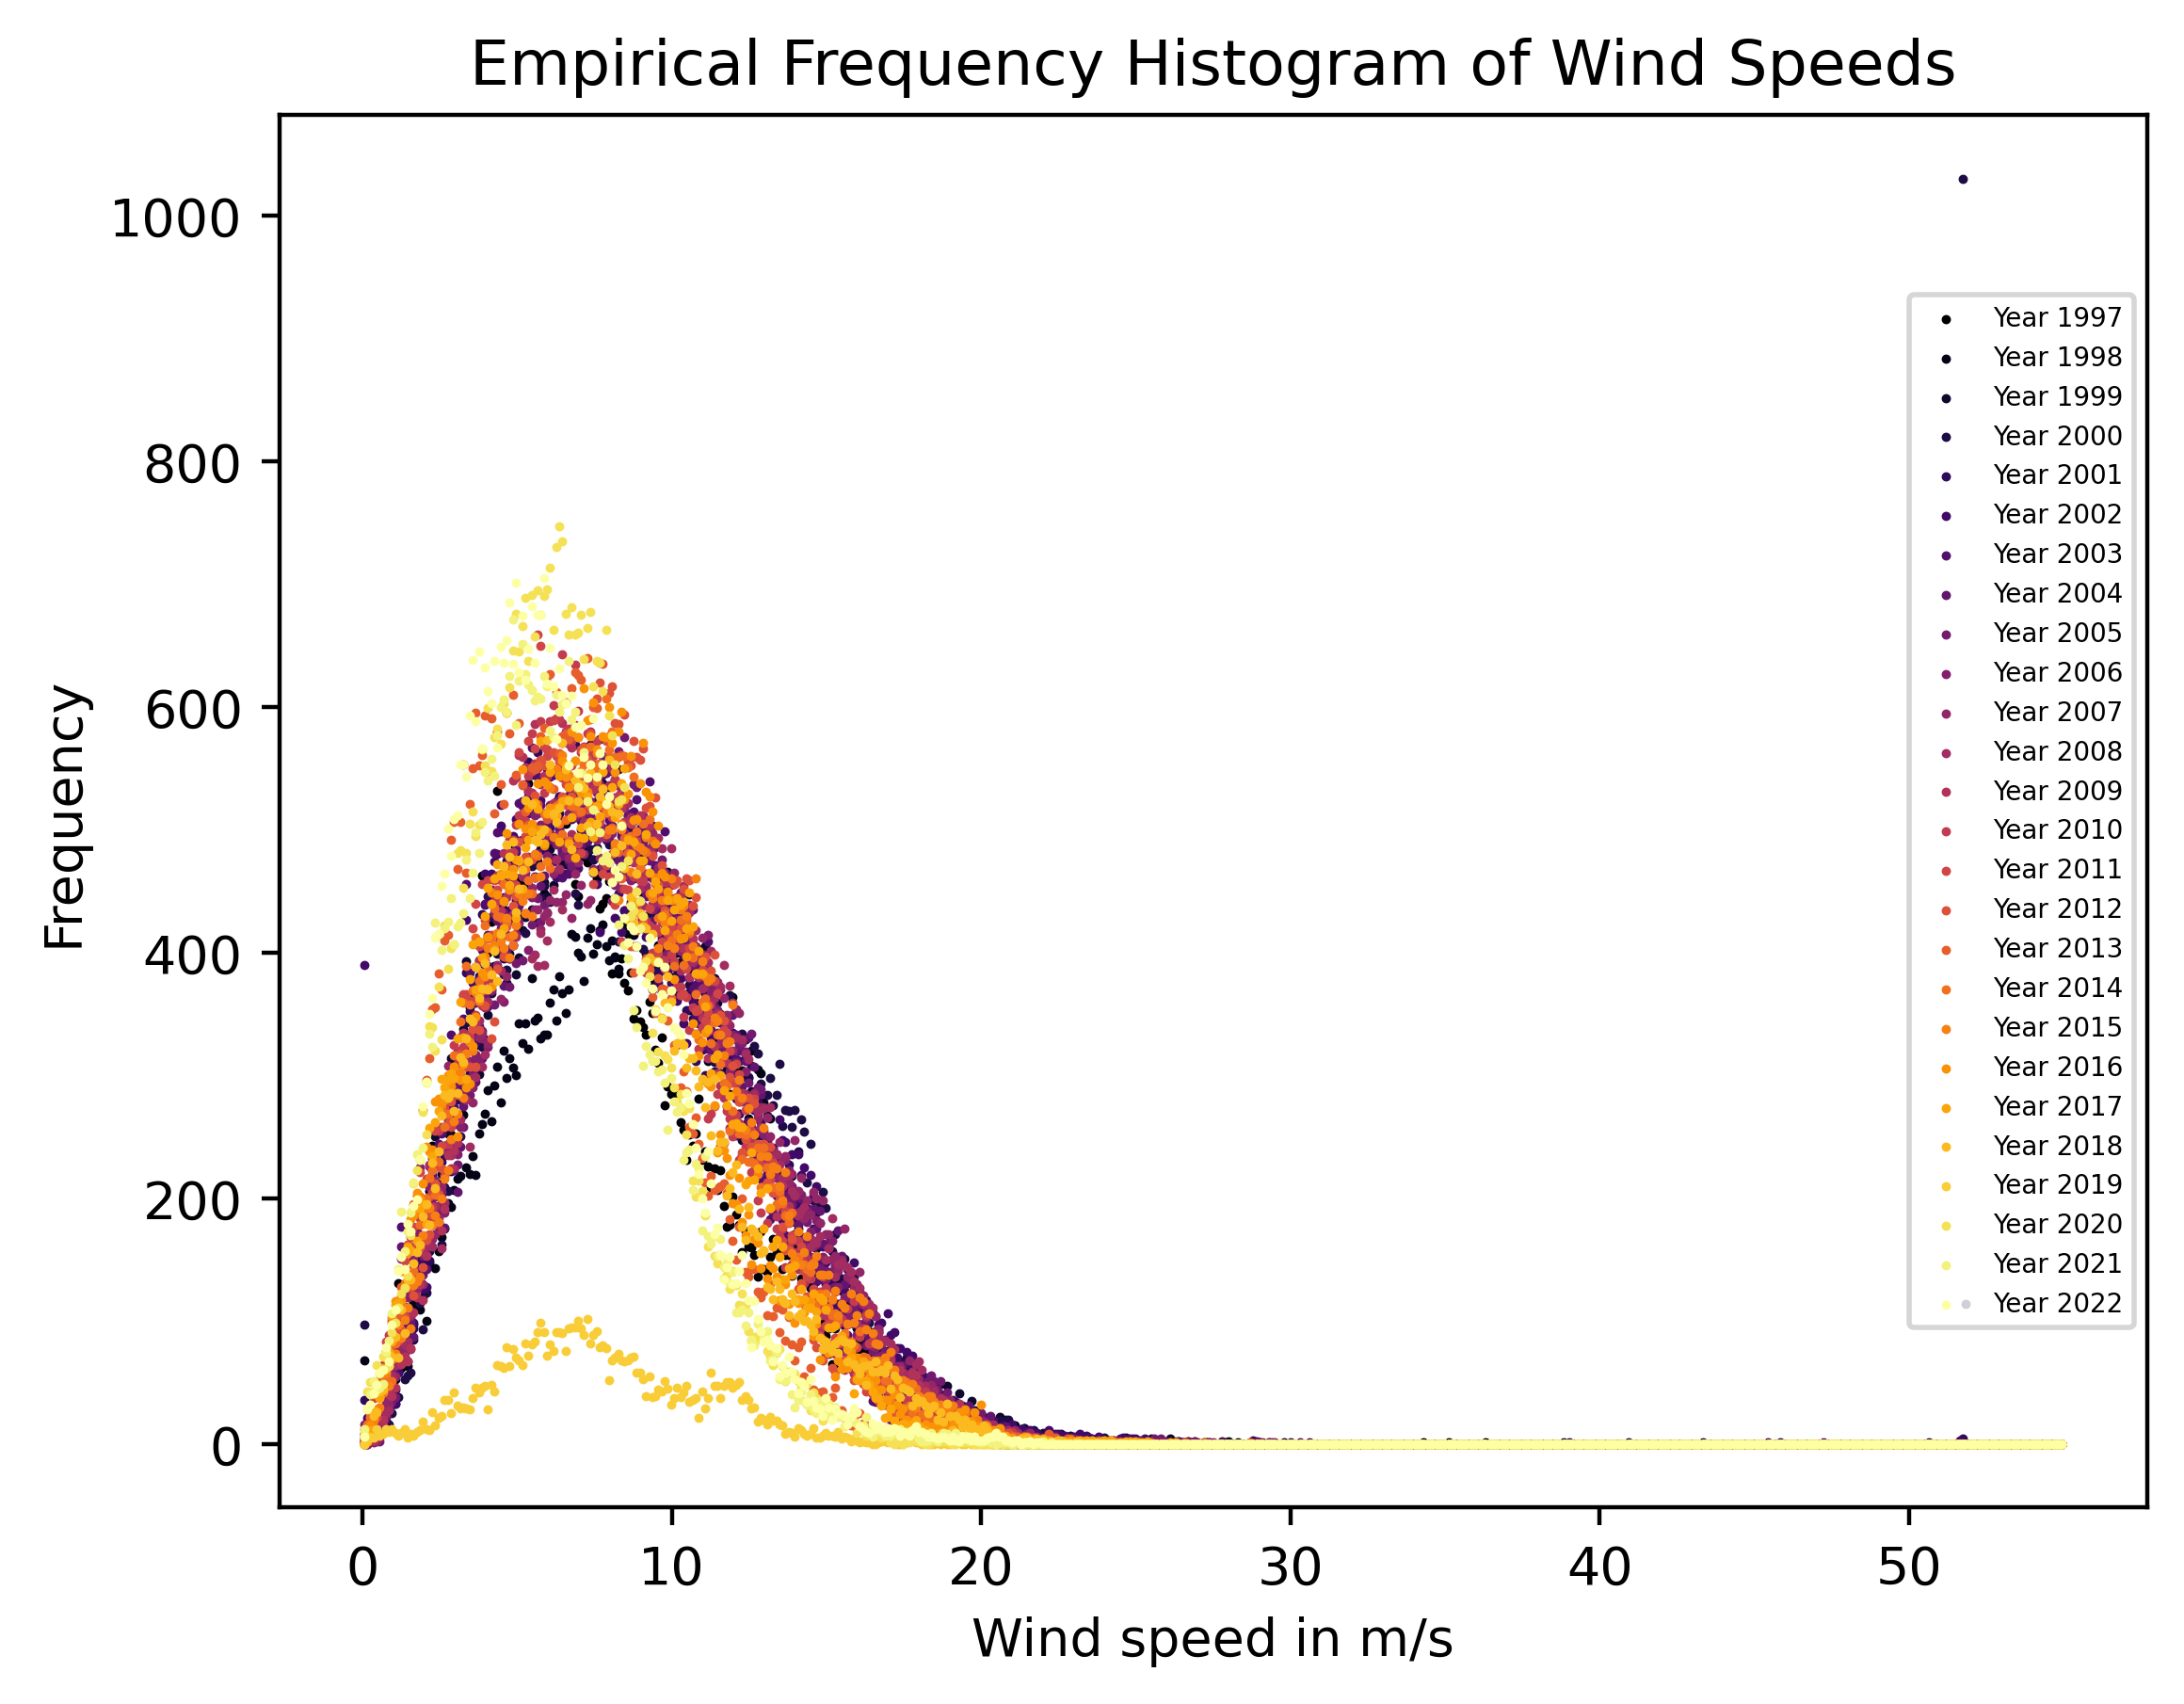

In [311]:
# plot the empirical frequency of each windspeed  for each year: 


new_mask = (df['MESS_DATUM'].dt.year == 2022)


# Specify bin edges with specific width, start, and end
bin_edges = np.linspace(0, 55, 550) 
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the histogram using Matplotlib
#plt.hist(df[new_mask]["FF_10_wind"], bins=bin_edges, edgecolor='black')
#plt.hist(df[(df['MESS_DATUM'].dt.year == 1997)]["FF_10_wind"], bins=bin_edges, edgecolor='blue')


year_colors = plt.cm.inferno(np.linspace(0,1,26))
for y in range(1997, 2023):
    hist_values= np.histogram(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"], bins=bin_edges)[0]
    # Create a plot using midpoints and frequencies
    plt.scatter(bin_midpoints, hist_values, color= year_colors[y-1997], label=f'Year {y}', alpha=1, s=0.6)

plt.title('Empirical Frequency Histogram of Wind Speeds')
plt.xlabel('Wind speed in m/s')
plt.ylabel('Frequency')
plt.legend(loc='right', fontsize='5')
plt.show()




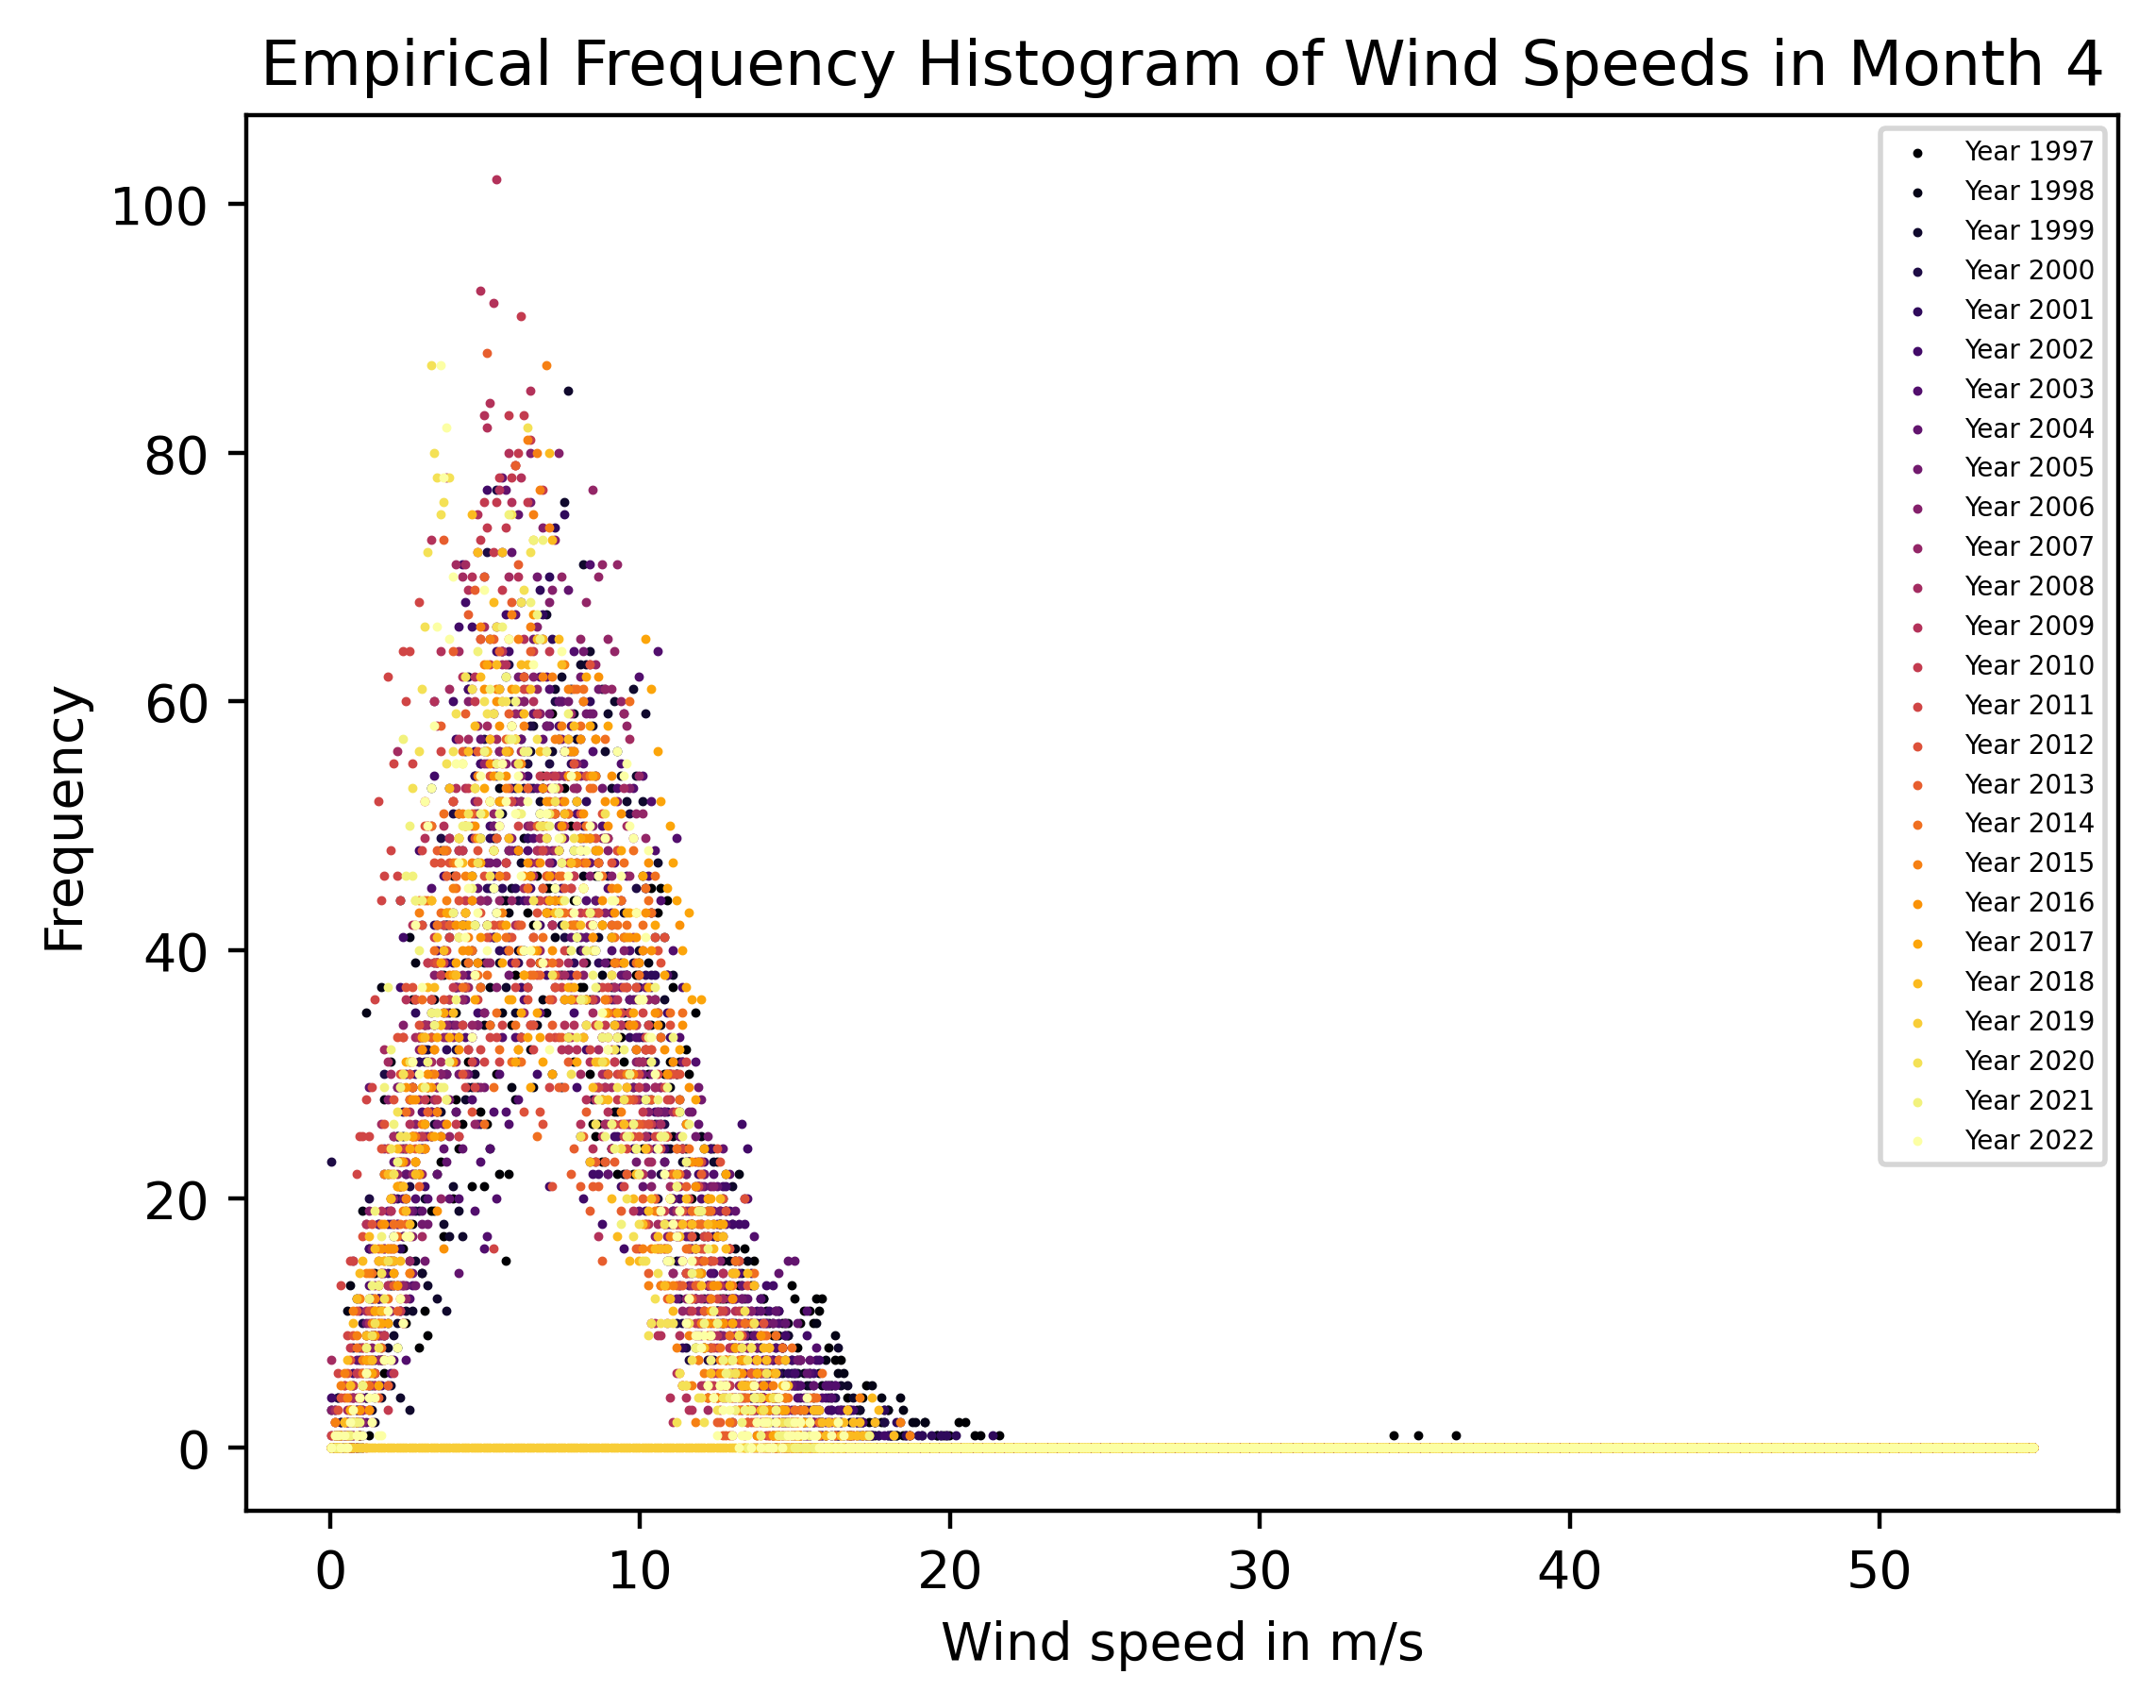

In [315]:
# plot the empirical frequency for a given month for each year: 
month=4
for y in range(1997, 2023):
    hist_values= np.histogram(df[(df['MESS_DATUM'].dt.year == y) & (df['MESS_DATUM'].dt.month == month) ]["FF_10_wind"], bins=bin_edges)[0]
    # Create a scatter plot using midpoints and frequencies
    plt.scatter(bin_midpoints, hist_values, color= year_colors[y-1997], label=f'Year {y}', alpha=1, s=0.6 )

plt.title(f'Empirical Frequency Histogram of Wind Speeds in Month {month}')
plt.xlabel('Wind speed in m/s')
plt.ylabel('Frequency')
plt.legend(loc='best', fontsize='5')
plt.show()



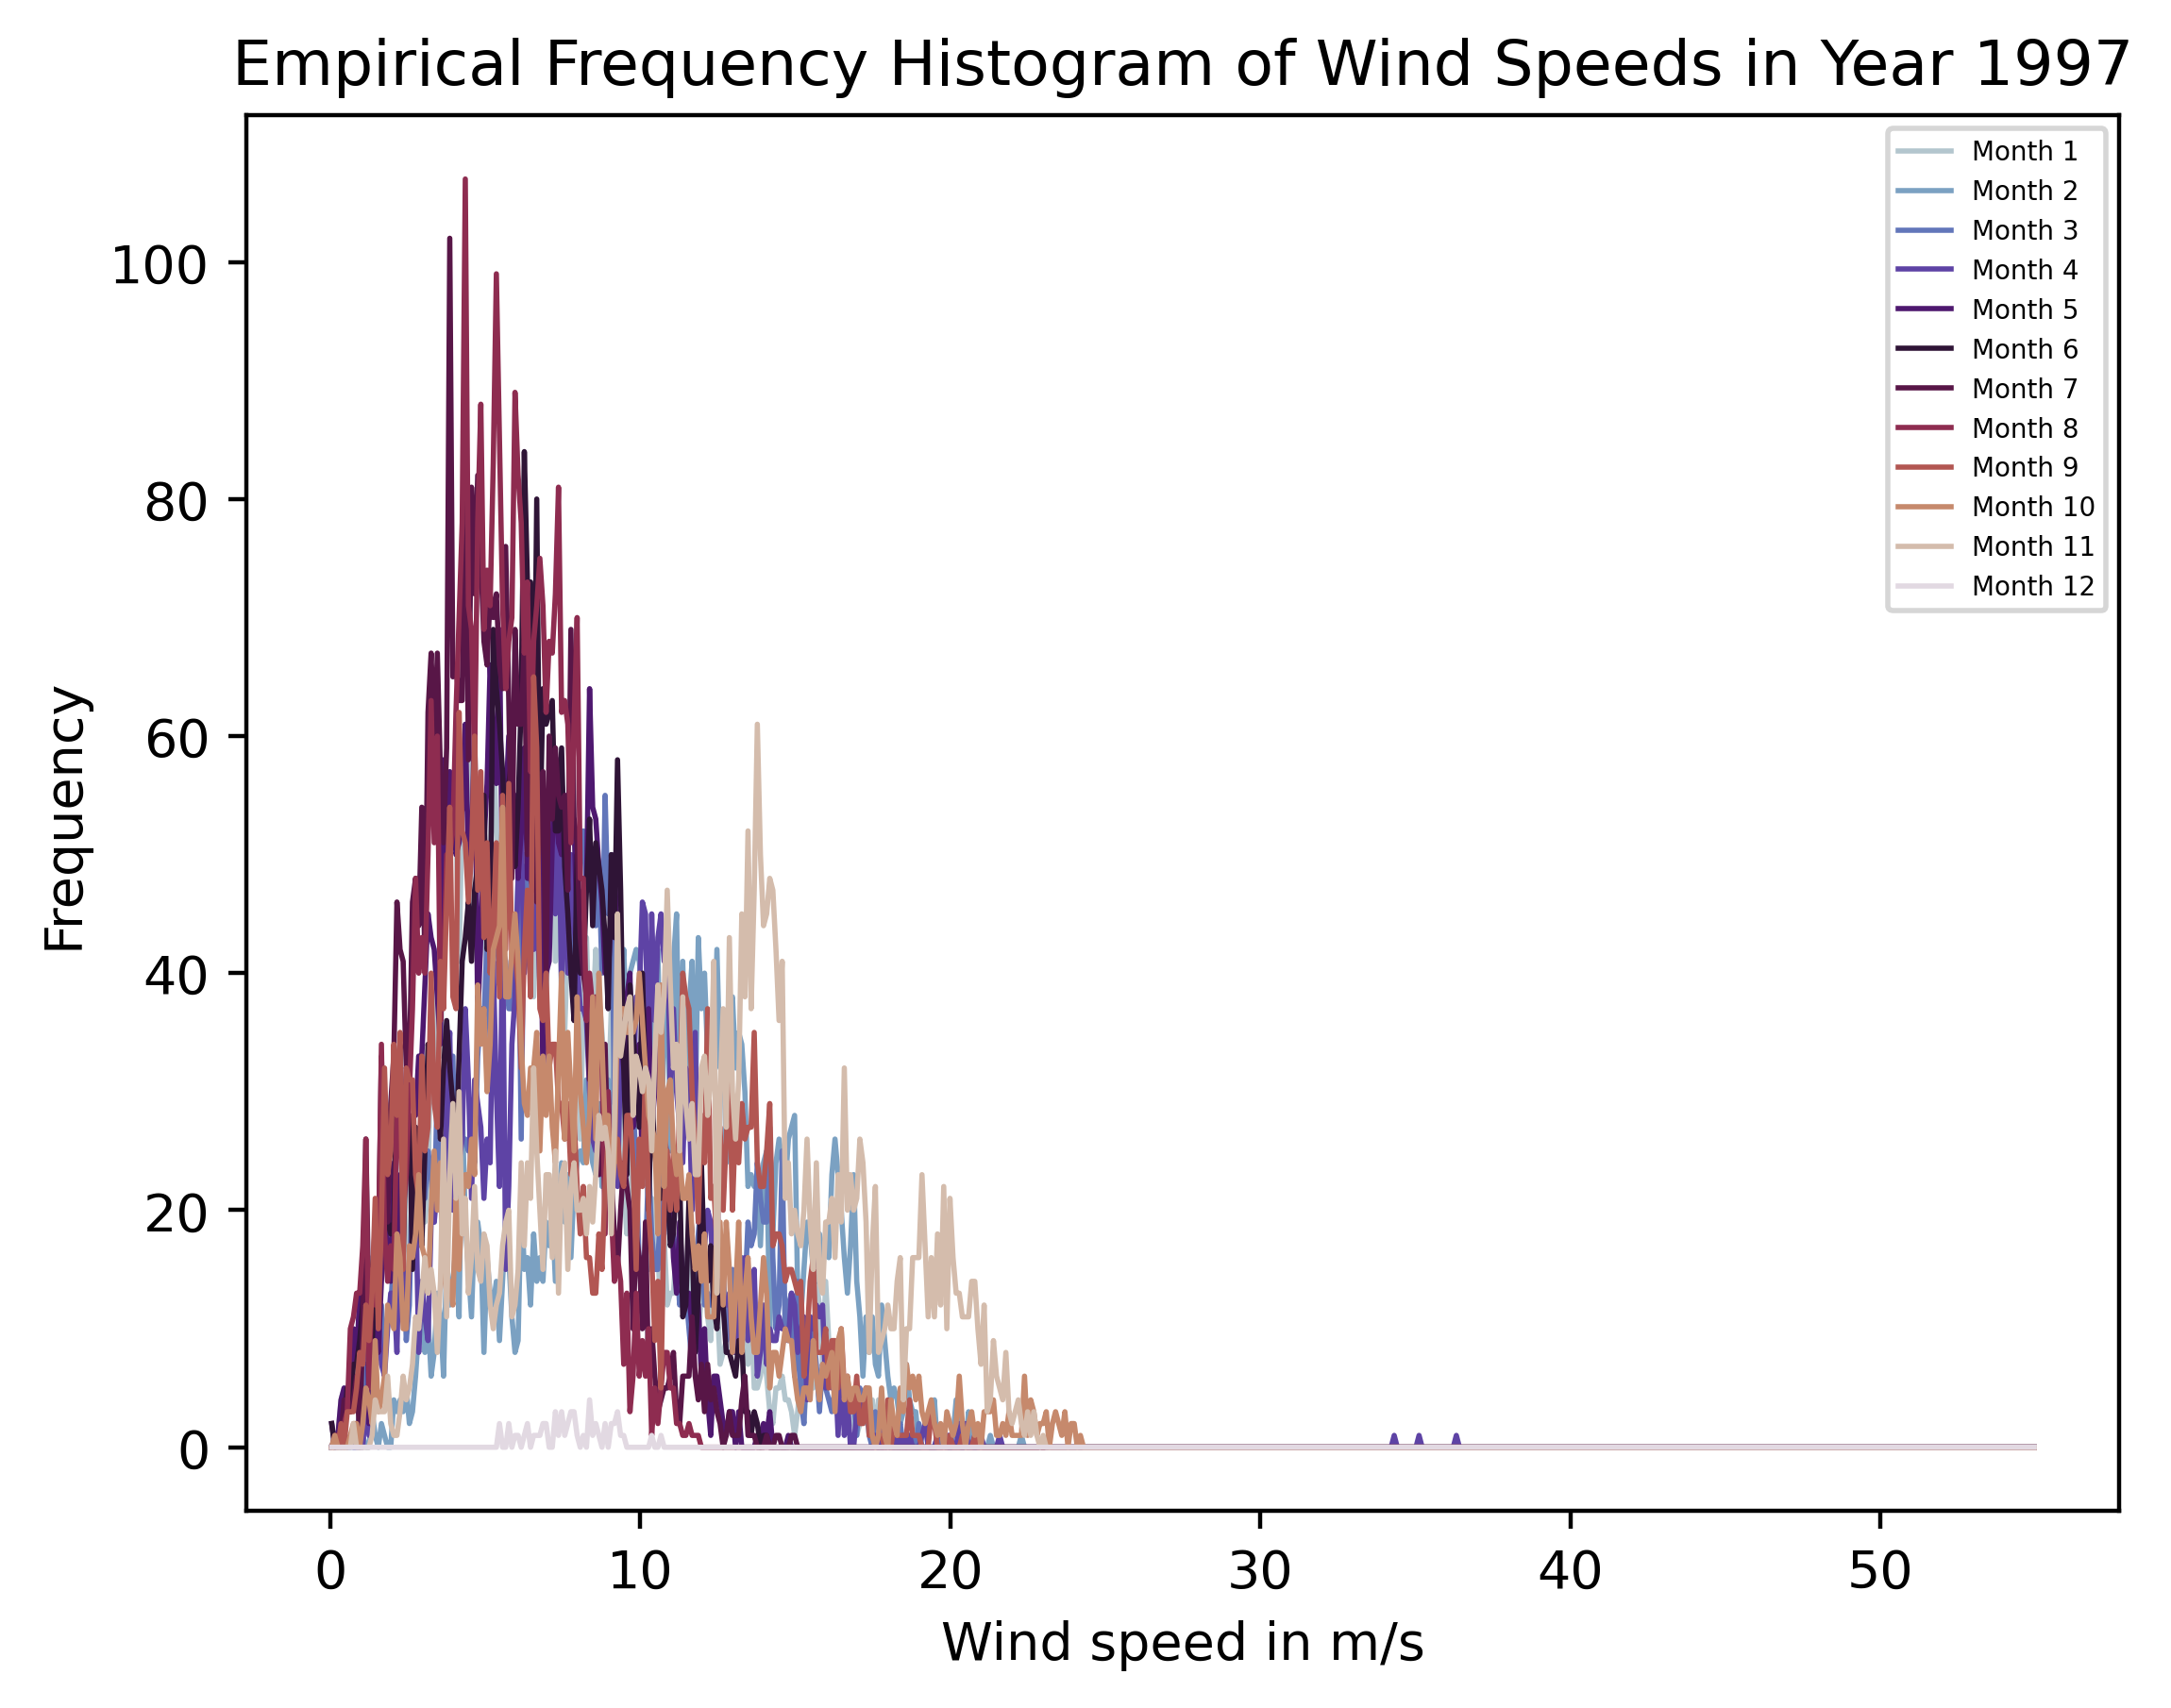

In [324]:
# plot the empirical frequency for a given year for each month: 

month_colors = plt.cm.twilight(np.linspace(0,1,13))
year=1997
for m in range(1, 13):
    hist_values= np.histogram(df[(df['MESS_DATUM'].dt.year == year) & (df['MESS_DATUM'].dt.month == m ) ]["FF_10_wind"], bins=bin_edges)[0]
    # Create a scatter plot using midpoints and frequencies
    plt.plot(bin_midpoints, hist_values, color= month_colors[m], label=f'Month {m}', alpha=1, lw=1 )

plt.title(f'Empirical Frequency Histogram of Wind Speeds in Year {year}')
plt.xlabel('Wind speed in m/s')
plt.ylabel('Frequency')
plt.legend(loc='best', fontsize='5')
plt.show()

In [217]:
from datetime import datetime
# Find all the storms, as classified by the Beaufort-scale
storm_df=df.copy() 
storm_df=storm_df.loc[storm_df["FF_10_wind"] >=24.5]
#for i in storm_df.index:
  #print(i)
  #print(f'This is the row: {storm_df.loc[i, "FF_10_wind"]}')
  #if storm_df.loc[i, "FF_10_wind"] < 250:
   #storm_df.drop(i, inplace = True)
  

#print(storm_df)
#plt.scatter( storm_df['MESS_DATUM'],storm_df['FF_10_wind'] )
#plt.show()

maxstorm_df=storm_df.copy()
storm_df.reset_index(drop=True, inplace=True)
# for each stormy day only keep the data point with the max windsped
current_date=datetime(1000, 1 , 1)
current_max_speed=0
maxdict=dict()

for i in maxstorm_df.index :
    # add a new dictionary entry, wehenever a new day begins 
    if  (current_date != maxstorm_df.loc[i, 'MESS_DATUM'].date()):
        current_date=maxstorm_df.loc[i, 'MESS_DATUM'].date()
        #print(maxstorm_df.loc[i, 'MESS_DATUM'].date())
        #print(current_date)
        maxdict[current_date]=0
    if maxdict[current_date]< maxstorm_df.loc[i, "FF_10_wind"]:
        maxdict[current_date]=maxstorm_df.loc[i, "FF_10_wind"]



'''
for i in maxstorm_df.index :
    if i < l-1:
        if (maxstorm_df.loc[i, "FF_10_wind"] == maxstorm_df.loc[i+1, "FF_10_wind"]):
            maxstorm_df.drop(i, inplace = True)
'''

for i in maxstorm_df.index :
    if maxdict[maxstorm_df.loc[i, 'MESS_DATUM'].date()] != maxstorm_df.loc[i, "FF_10_wind"]:
        maxstorm_df.drop(i, inplace = True)


maxstorm_df.reset_index(drop=True, inplace=True)
l=len(maxstorm_df)
for i in maxstorm_df.index :
    if i < l-1:
        if (maxstorm_df.loc[i, "MESS_DATUM"].date() == maxstorm_df.loc[i+1, "MESS_DATUM"].date()):
            maxstorm_df.drop(i, inplace = True)





In [218]:
# Find df for a beaufort 9 but not a 10
bf9_df=df.copy() 
bf9_df=bf9_df.loc[bf9_df["FF_10_wind"] >=20.8 ]

bf9_df=bf9_df.loc[bf9_df["FF_10_wind"] <24.5 ]

#find individual days

bf9_days_df=bf9_df.copy()
bf9_days_df.reset_index(drop=True, inplace=True)
l9=len(bf9_days_df)
for i in bf9_days_df.index :
    if i < l9-1:
        if (bf9_days_df.loc[i, "MESS_DATUM"].date() == bf9_days_df.loc[i+1, "MESS_DATUM"].date()):
            bf9_days_df.drop(i, inplace = True)

In [241]:
# Find df for a beaufort 8 but not a 9
bf8_df=df.copy() 
bf8_df=bf8_df.loc[bf8_df["FF_10_wind"] >=17.2 ]

bf8_df=bf8_df.loc[bf8_df["FF_10_wind"] <20.8 ]

#find individual days

bf8_days_df=bf8_df.copy()
bf8_days_df.reset_index(drop=True, inplace=True)
l8=len(bf8_days_df)
for i in bf8_days_df.index :
    if i < l8-1:
        if (bf8_days_df.loc[i, "MESS_DATUM"].date() == bf8_days_df.loc[i+1, "MESS_DATUM"].date()):
            bf8_days_df.drop(i, inplace = True)

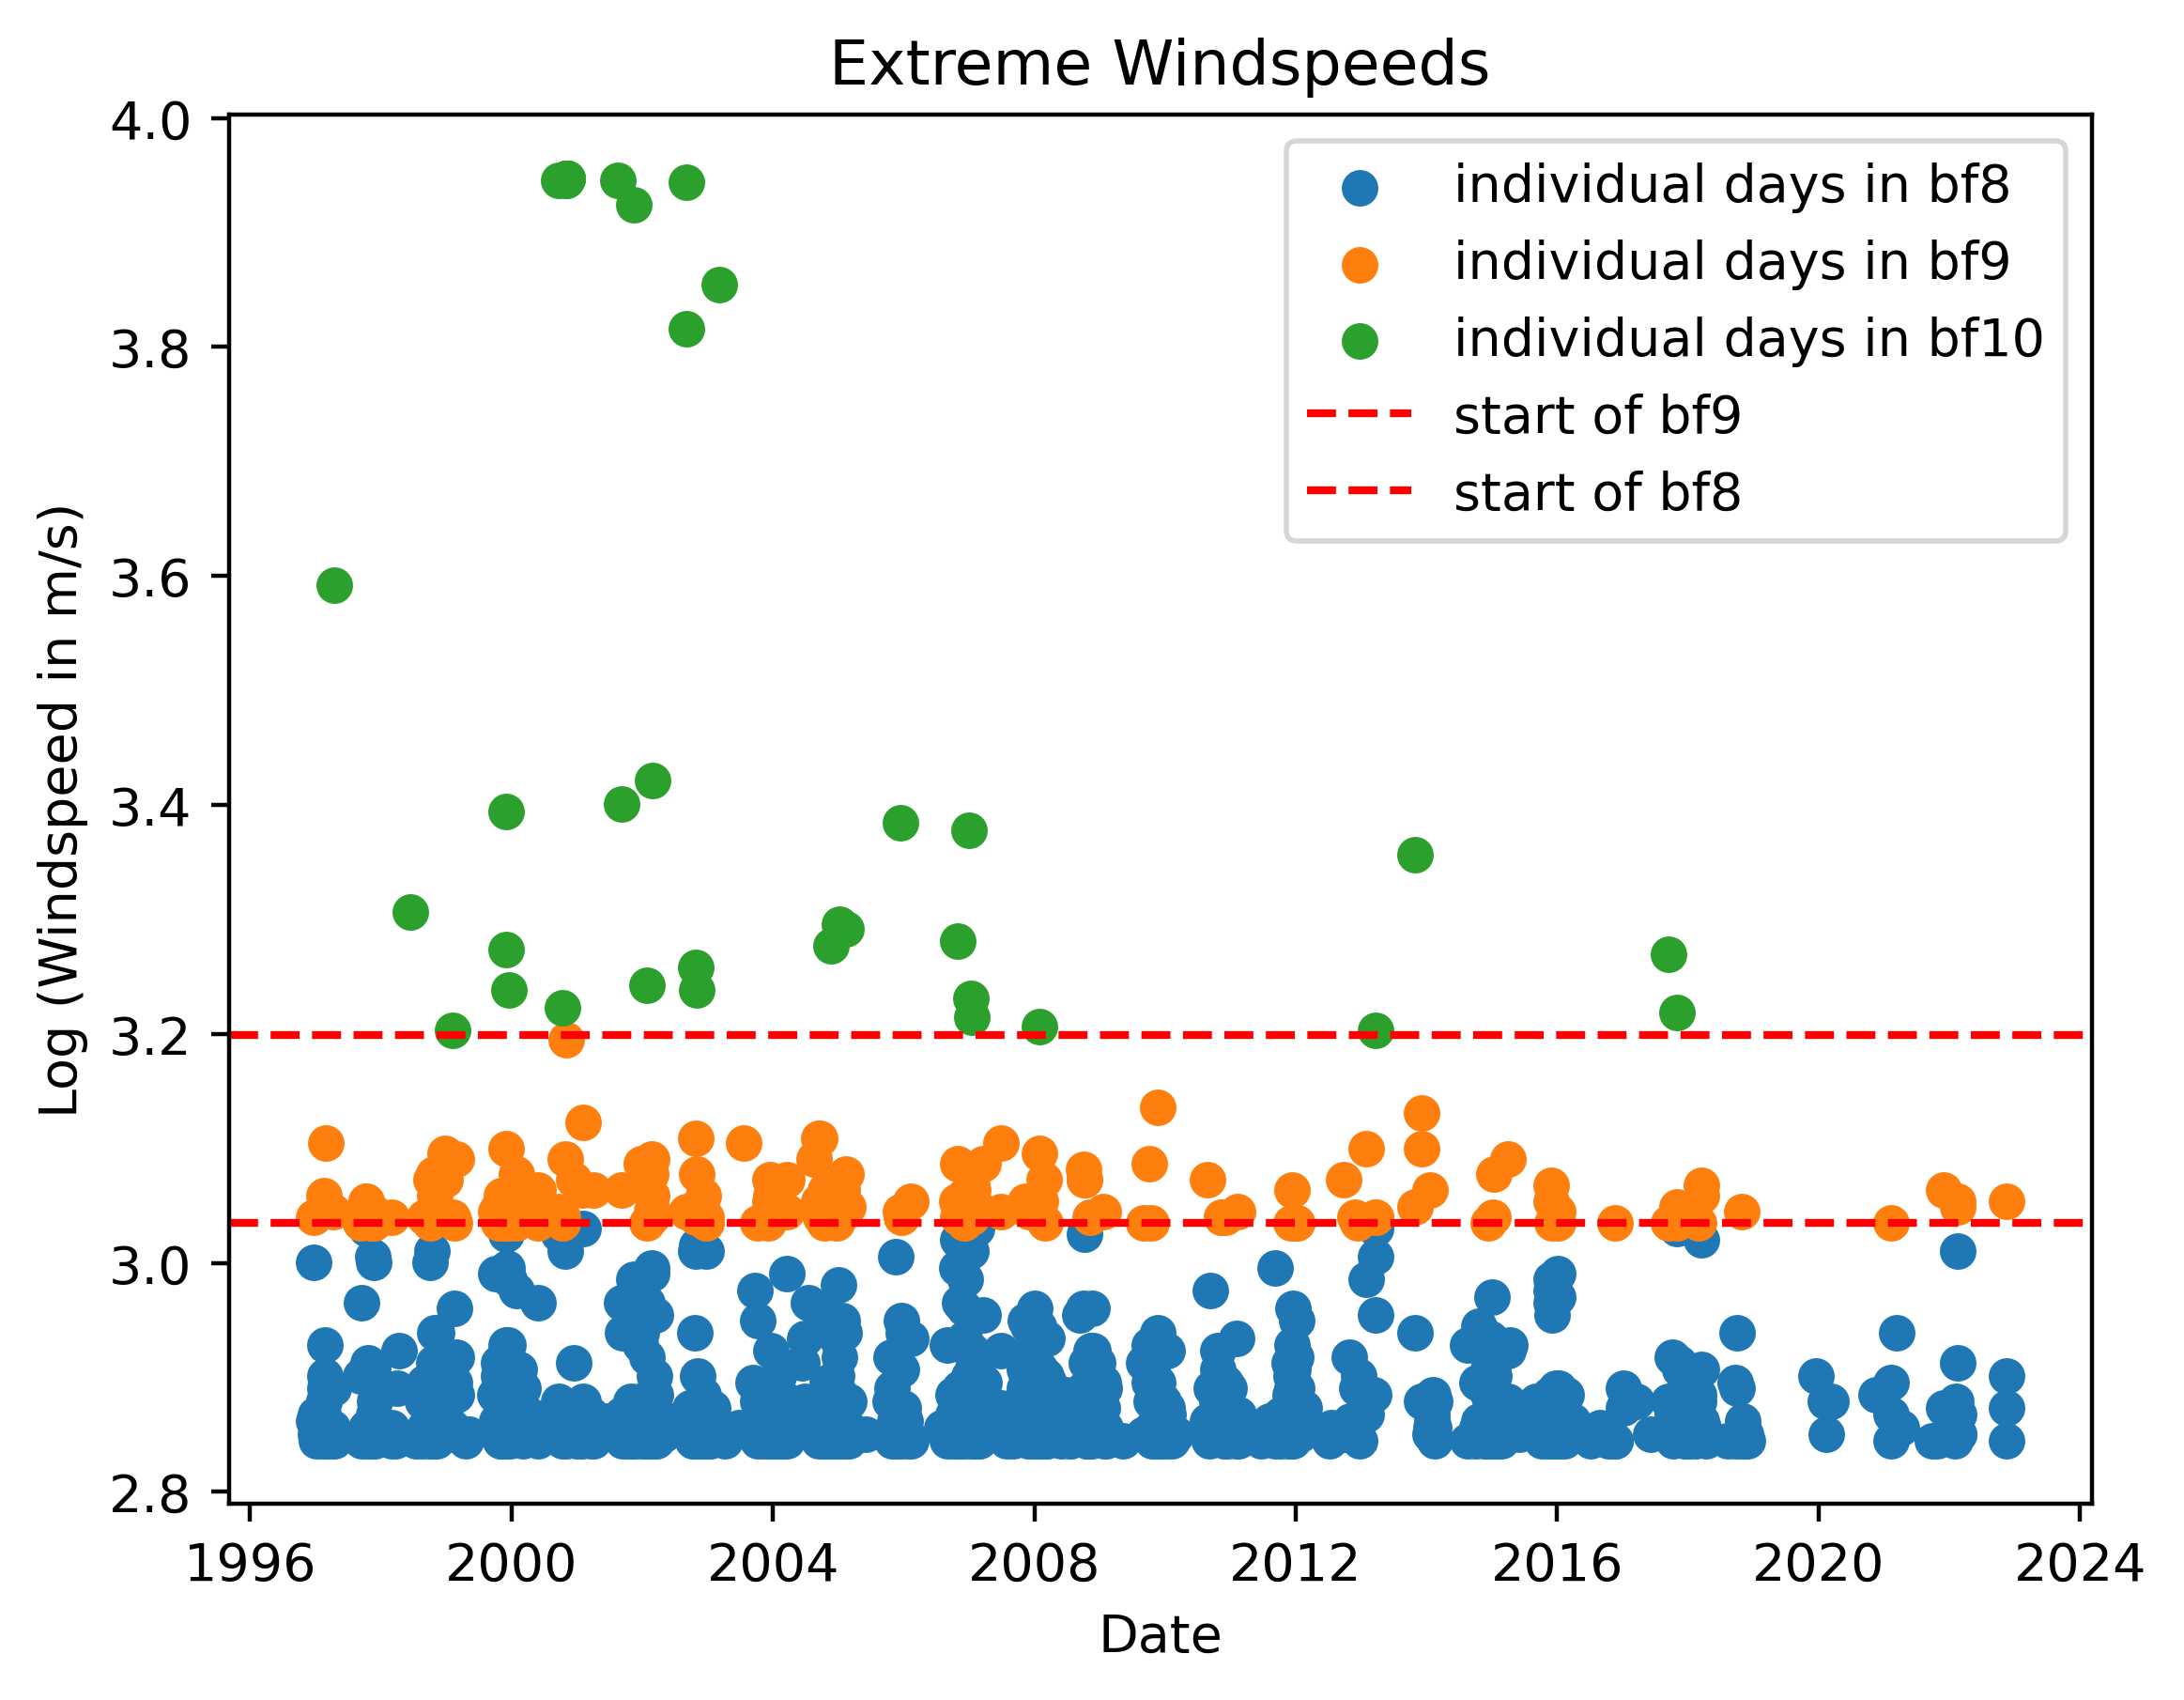

'\nplt.scatter(np.linspace(0, len(maxstorm_df), len(maxstorm_df)),maxstorm_df["FF_10_wind"])\nplt.show()\n\nplt.scatter(np.linspace(0, len(bf9_days_df), len(bf9_days_df)),bf9_days_df["FF_10_wind"])\nplt.show()\n'

In [259]:

plt.scatter(bf8_days_df["MESS_DATUM"],np.log(bf8_days_df["FF_10_wind"]), label='individual days in bf8')
plt.scatter(bf9_days_df["MESS_DATUM"],np.log(bf9_days_df["FF_10_wind"]), label='individual days in bf9')
#plt.scatter(storm_df["MESS_DATUM"],storm_df["FF_10_wind"], label='all data points in bf10')
plt.scatter(maxstorm_df["MESS_DATUM"],np.log(maxstorm_df["FF_10_wind"]), label='individual days in bf10')

plt.axhline(y=np.log(24.5), color='red', linestyle='--', label='start of bf9')

plt.axhline(y=np.log(20.8), color='red', linestyle='--', label='start of bf8')

plt.title('Extreme Windspeeds')
plt.xlabel('Date')
plt.ylabel('Log (Windspeed in m/s)')
plt.legend(loc='best')
plt.show()

'''
plt.scatter(np.linspace(0, len(maxstorm_df), len(maxstorm_df)),maxstorm_df["FF_10_wind"])
plt.show()

plt.scatter(np.linspace(0, len(bf9_days_df), len(bf9_days_df)),bf9_days_df["FF_10_wind"])
plt.show()
'''


#maxstorm_df.to_csv('storm_data2.csv', index=False, sep='\t', header=True)

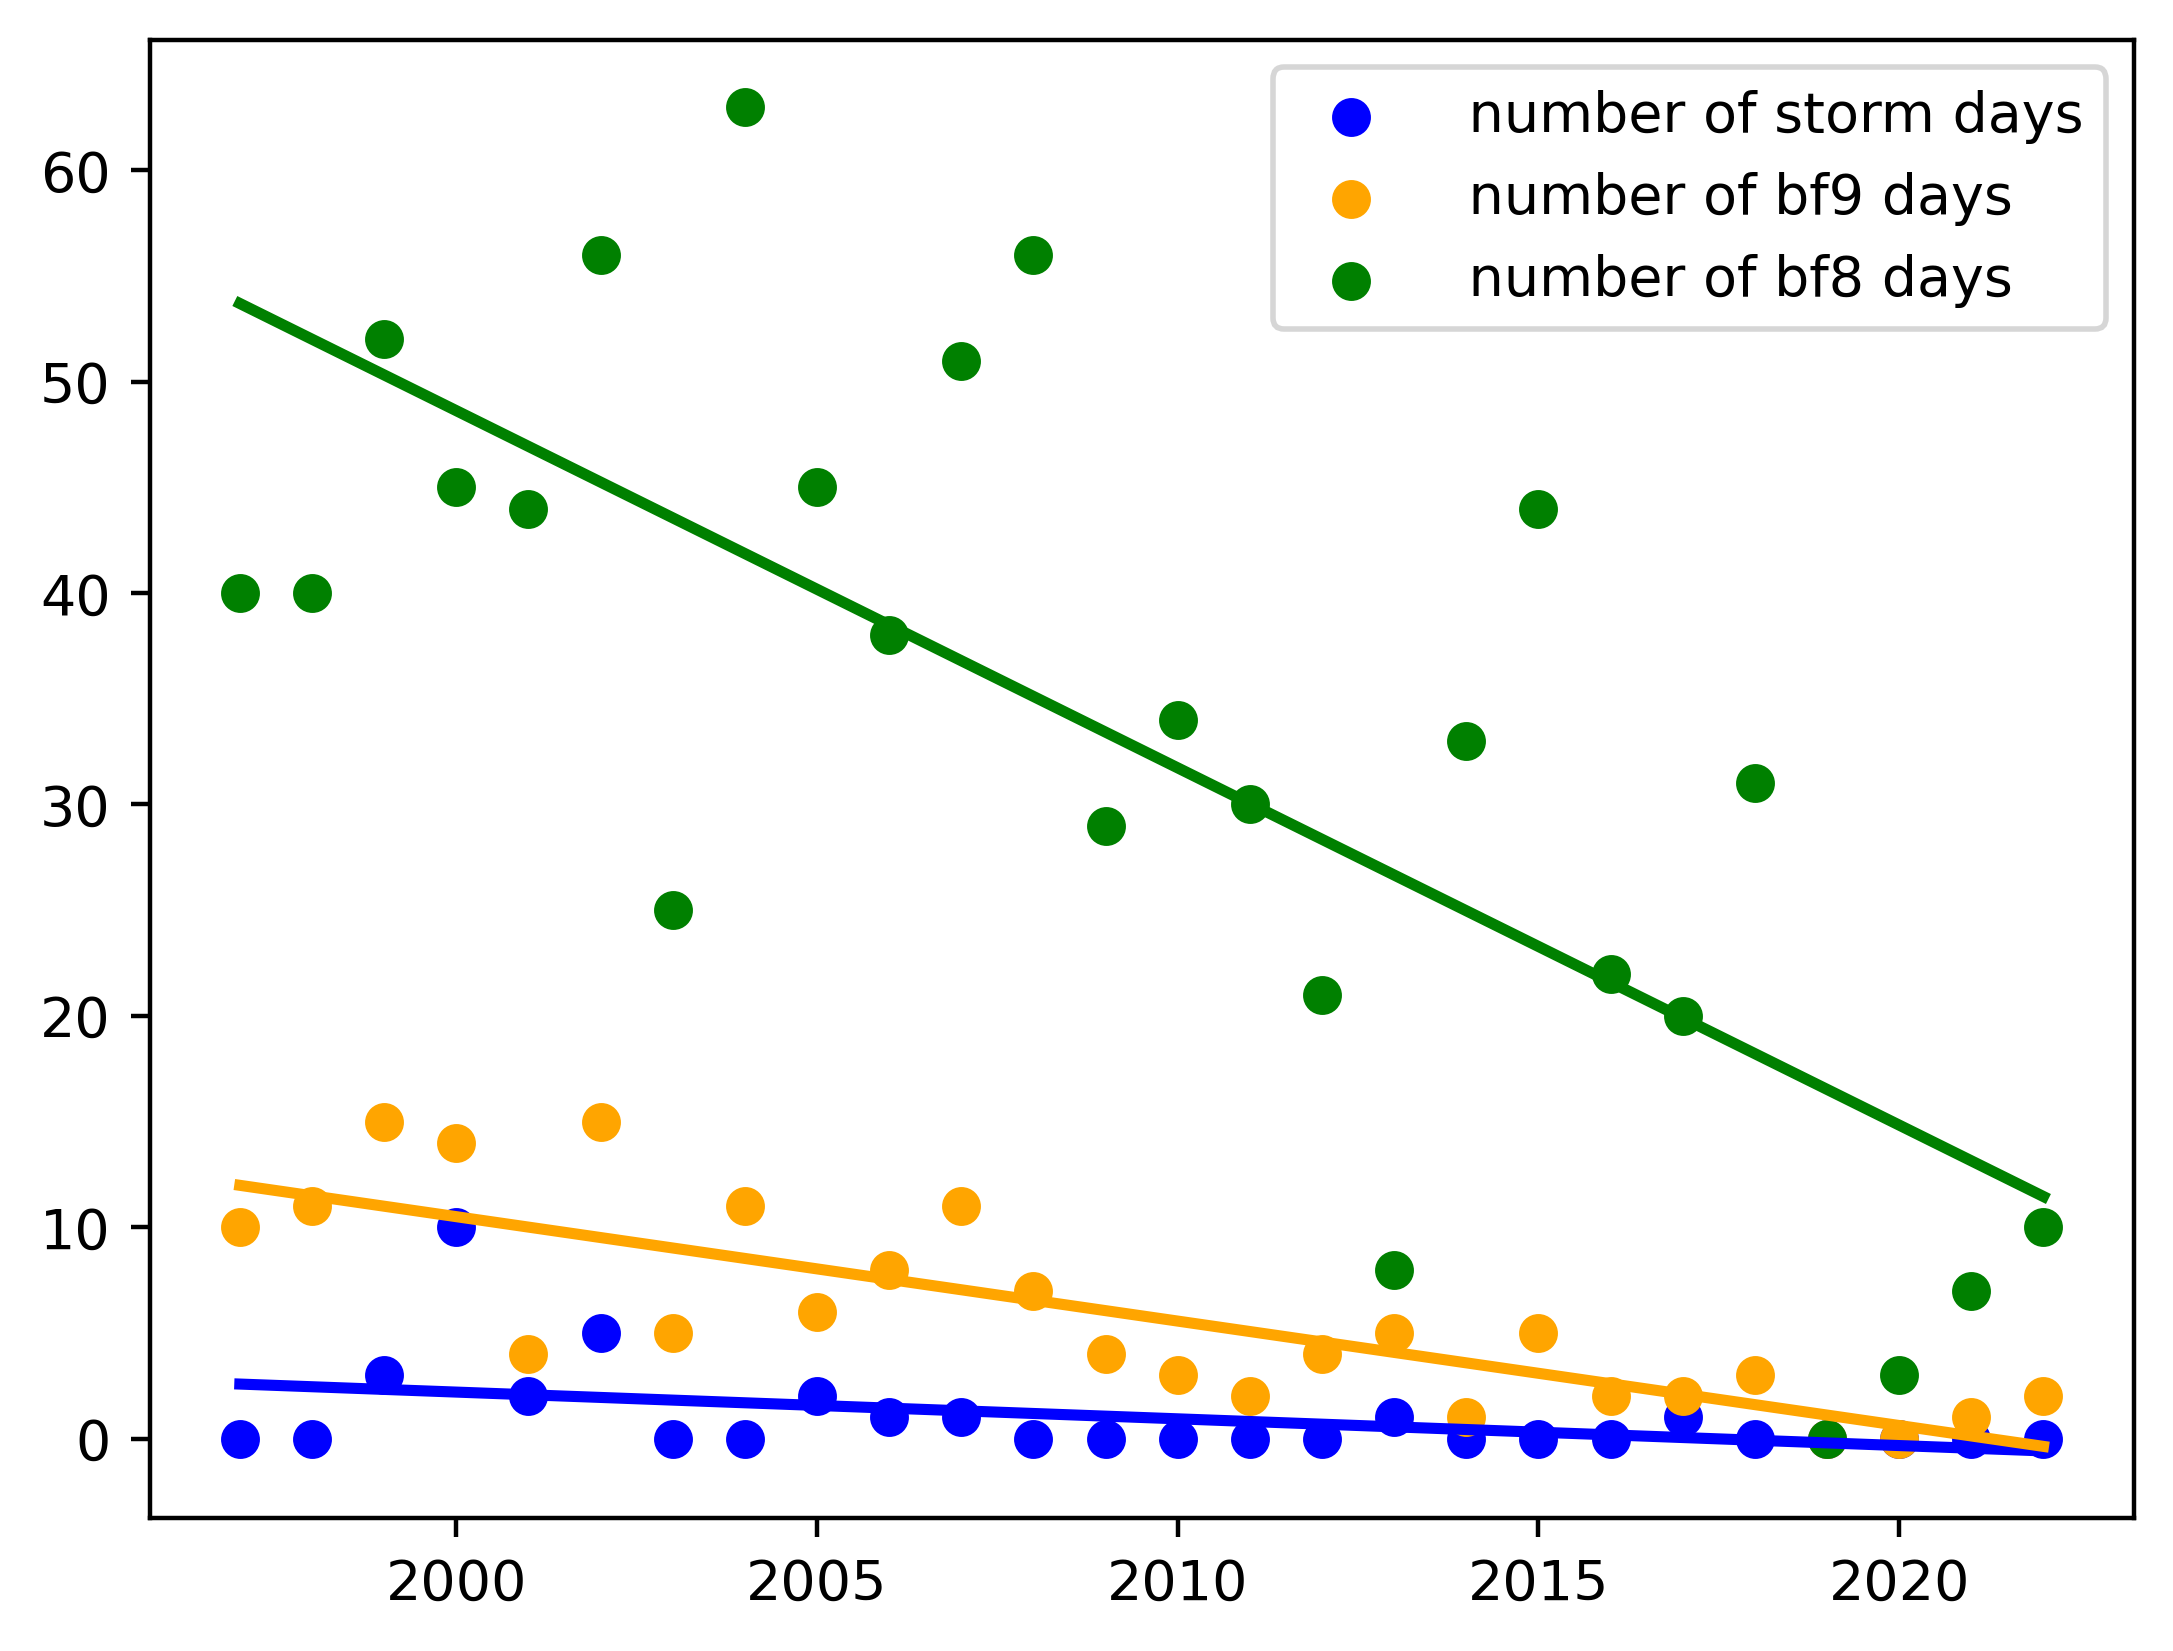

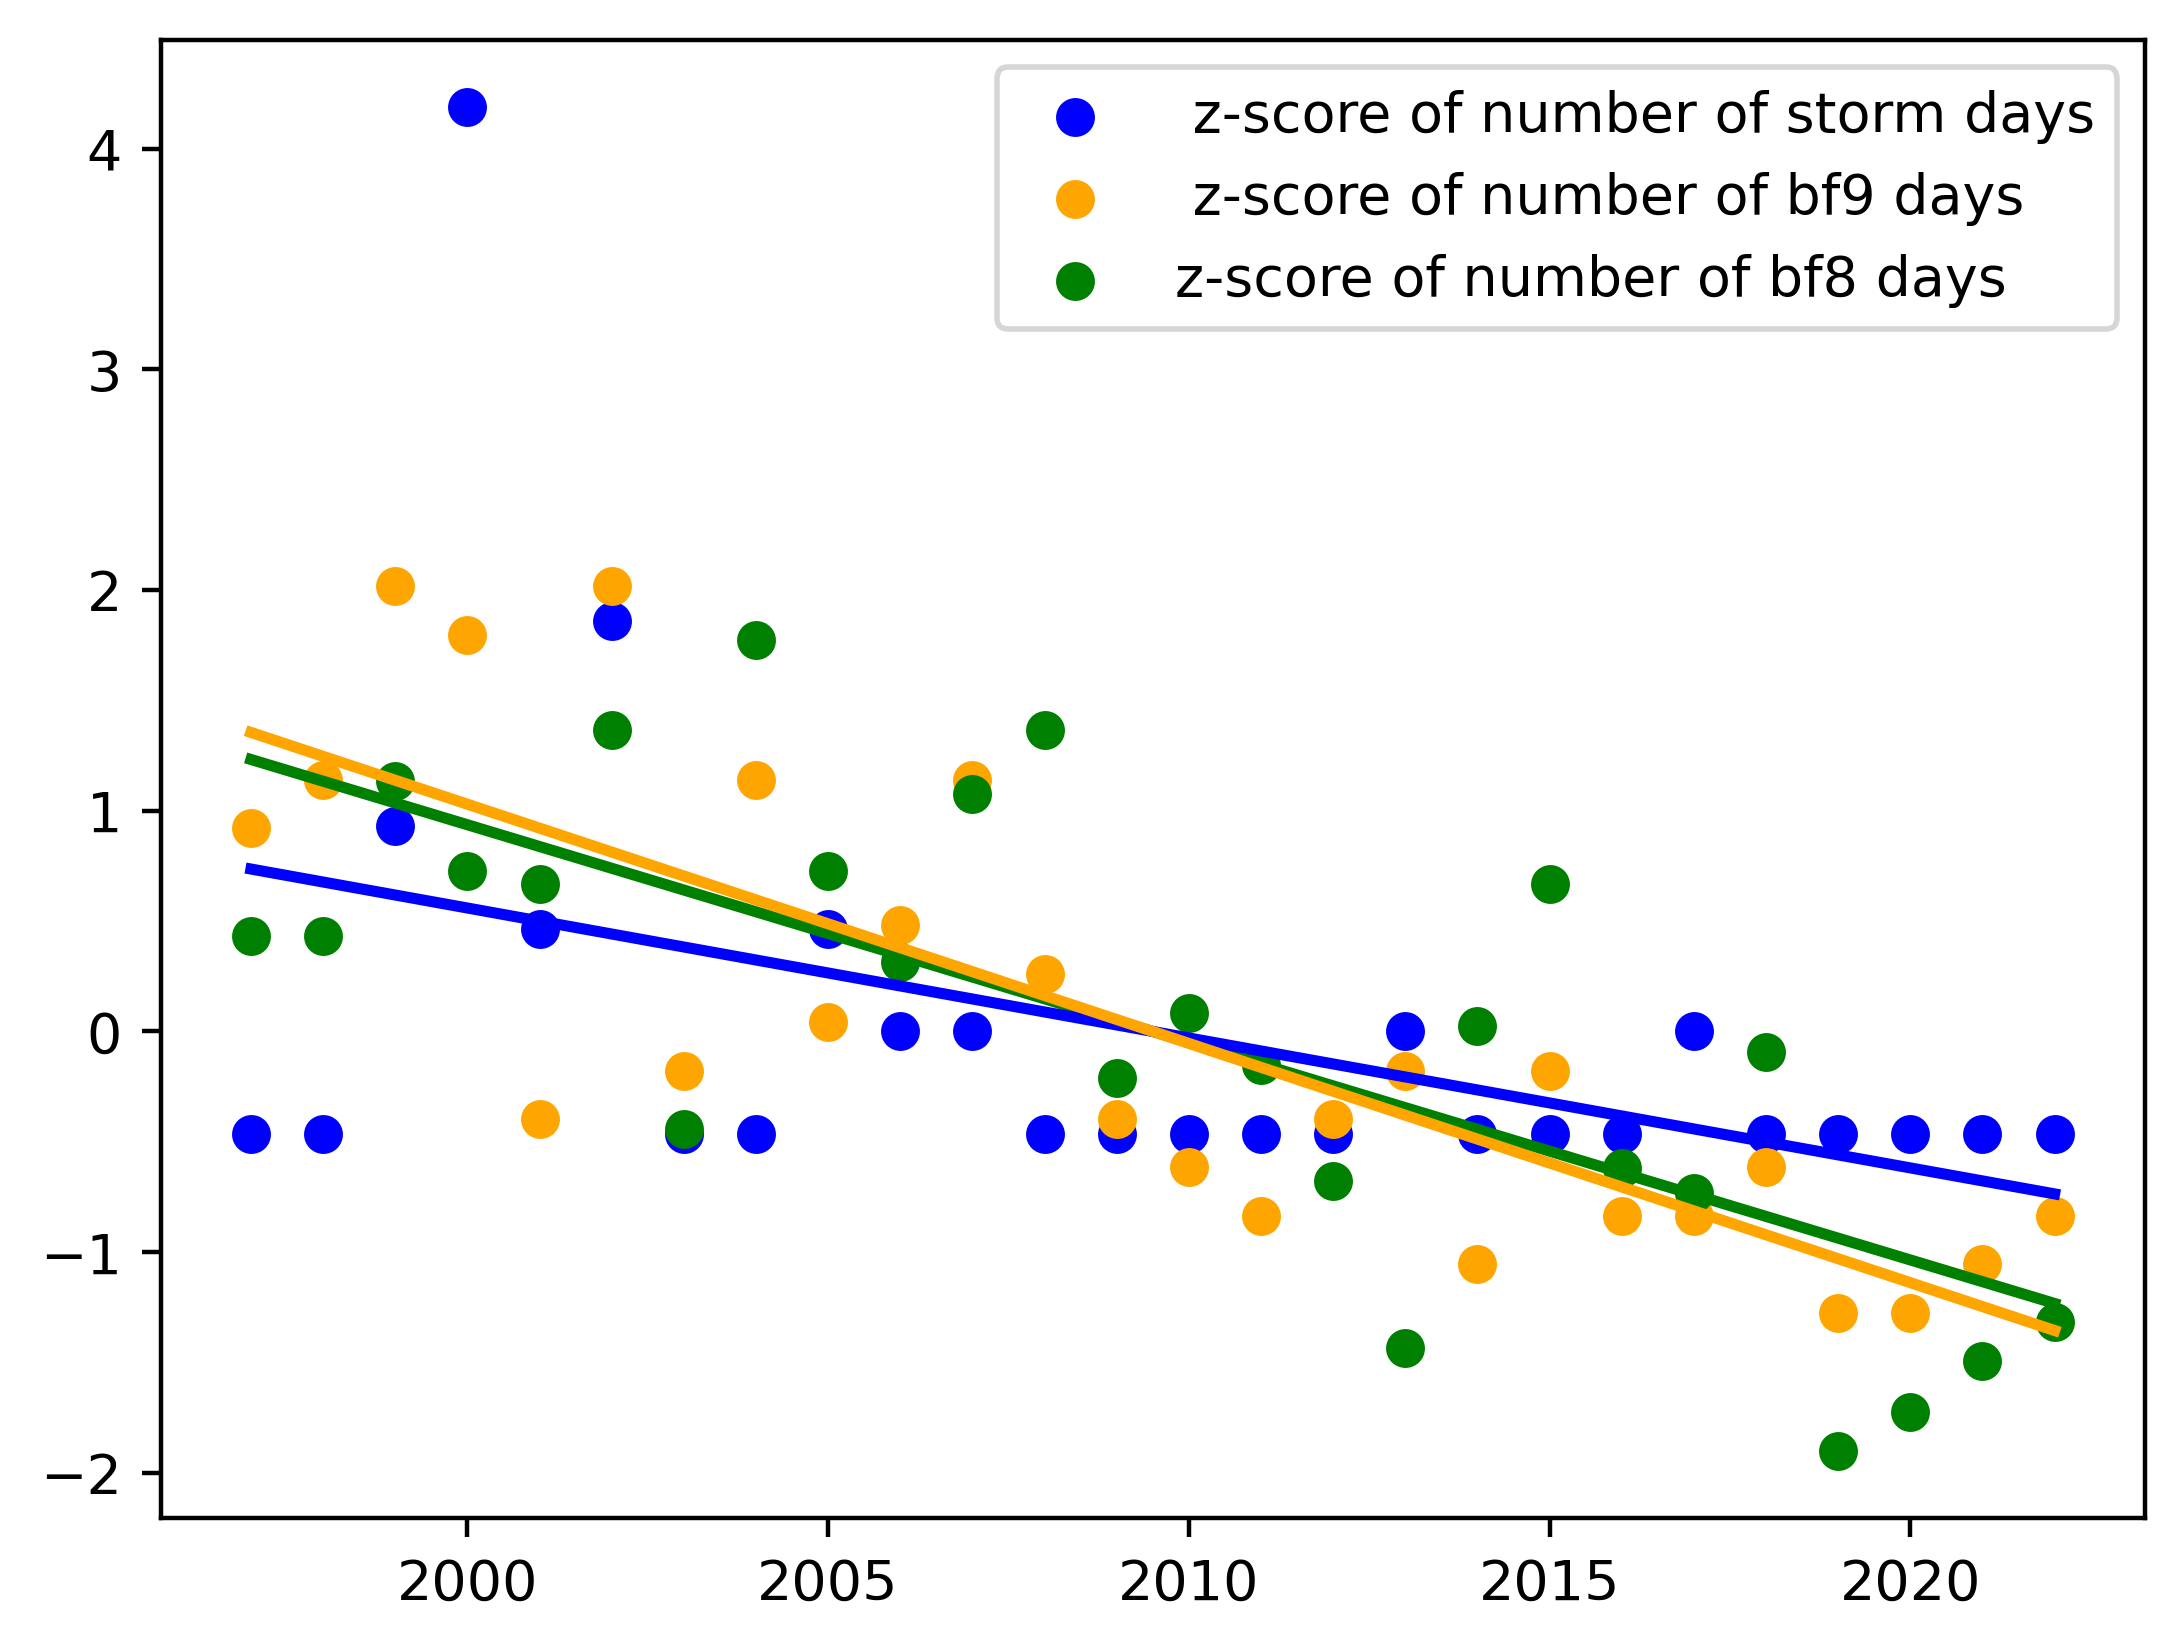

In [270]:
# plot the number of extreme windspeeds by year
xarr=np.arange(1997, 2023)

number_of_stormy_days=dict()
number_of_bf9_days=dict()
number_of_bf8_days=dict()

for i in maxstorm_df.index:
    if maxstorm_df.loc[i, "MESS_DATUM"].year not in number_of_stormy_days:
        number_of_stormy_days[maxstorm_df.loc[i, "MESS_DATUM"].year]=0
    else:
        number_of_stormy_days[maxstorm_df.loc[i, "MESS_DATUM"].year]+=1


for i in bf9_days_df.index:
    if bf9_days_df.loc[i, "MESS_DATUM"].year not in number_of_bf9_days:
        number_of_bf9_days[bf9_days_df.loc[i, "MESS_DATUM"].year]=0
    else:
        number_of_bf9_days[bf9_days_df.loc[i, "MESS_DATUM"].year]+=1

for i in bf8_days_df.index:
    if bf8_days_df.loc[i, "MESS_DATUM"].year not in number_of_bf8_days:
        number_of_bf8_days[bf8_days_df.loc[i, "MESS_DATUM"].year]=0
    else:
        number_of_bf8_days[bf8_days_df.loc[i, "MESS_DATUM"].year]+=1

# turn dictionarys to arrays
storm_arr= np.empty([1,0])
for i in range(0, len(xarr)):
   if xarr[i] in number_of_stormy_days:
        storm_arr=np.append(storm_arr, number_of_stormy_days[xarr[i]])
   else:
      storm_arr=np.append(storm_arr,0) 

bf9_arr= np.empty([1,0])
for i in range(0, len(xarr)):
   if xarr[i] in number_of_bf9_days:
        bf9_arr=np.append(bf9_arr, number_of_bf9_days[xarr[i]])
   else:
      bf9_arr=np.append(bf9_arr,0) 

bf8_arr= np.empty([1,0])
for i in range(0, len(xarr)):
   if xarr[i] in number_of_bf8_days:
        bf8_arr=np.append(bf8_arr, number_of_bf8_days[xarr[i]])
   else:
      bf8_arr=np.append(bf8_arr,0) 


# polynomial regression and plotting
bf9_pol=np.polyfit(xarr, bf9_arr, 1)
bf9_model = np.poly1d(bf9_pol)

bf8_pol=np.polyfit(xarr, bf8_arr, 1)
bf8_model = np.poly1d(bf8_pol)

storm_pol=np.polyfit(xarr, storm_arr, 1)
storm_model = np.poly1d(storm_pol)

plt.scatter(xarr, storm_arr, color='blue', label=' number of storm days')
plt.scatter(xarr, bf9_arr,  color='orange', label=' number of bf9 days ')

plt.scatter(xarr, bf8_arr,  color='green', label=' number of bf8 days ')
plt.plot(xarr, bf8_model(xarr), color='green', linewidth = 2)
plt.plot(xarr, storm_model(xarr), color='blue', linewidth = 2)
plt.plot(xarr, bf9_model(xarr), color='orange', linewidth = 2)
plt.legend()
plt.show()


# Now plot the z-scores: 
z_bf9_arr=(bf9_arr- np.mean(bf9_arr))/np.std(bf9_arr)

z_bf8_arr=(bf8_arr- np.mean(bf8_arr))/np.std(bf8_arr)

z_storm_arr=(storm_arr- np.mean(storm_arr))/np.std(storm_arr)


z_bf9_pol=np.polyfit(xarr, z_bf9_arr, 1)
z_bf9_model = np.poly1d(z_bf9_pol)

z_bf8_pol=np.polyfit(xarr, z_bf8_arr, 1)
z_bf8_model = np.poly1d(z_bf8_pol)

z_storm_pol=np.polyfit(xarr, z_storm_arr, 1)
z_storm_model = np.poly1d(z_storm_pol)

plt.scatter(xarr, z_storm_arr, color='blue', label=' z-score of number of storm days')
plt.scatter(xarr, z_bf9_arr,  color='orange', label=' z-score of number of bf9 days ')
plt.scatter(xarr, z_bf8_arr,  color='green', label='z-score of number of bf8 days ')

plt.plot(xarr, z_bf8_model(xarr), color='green', linewidth = 2)
plt.plot(xarr, z_storm_model(xarr), color='blue', linewidth = 2)
plt.plot(xarr, z_bf9_model(xarr), color='orange', linewidth = 2)

plt.legend()
plt.show()




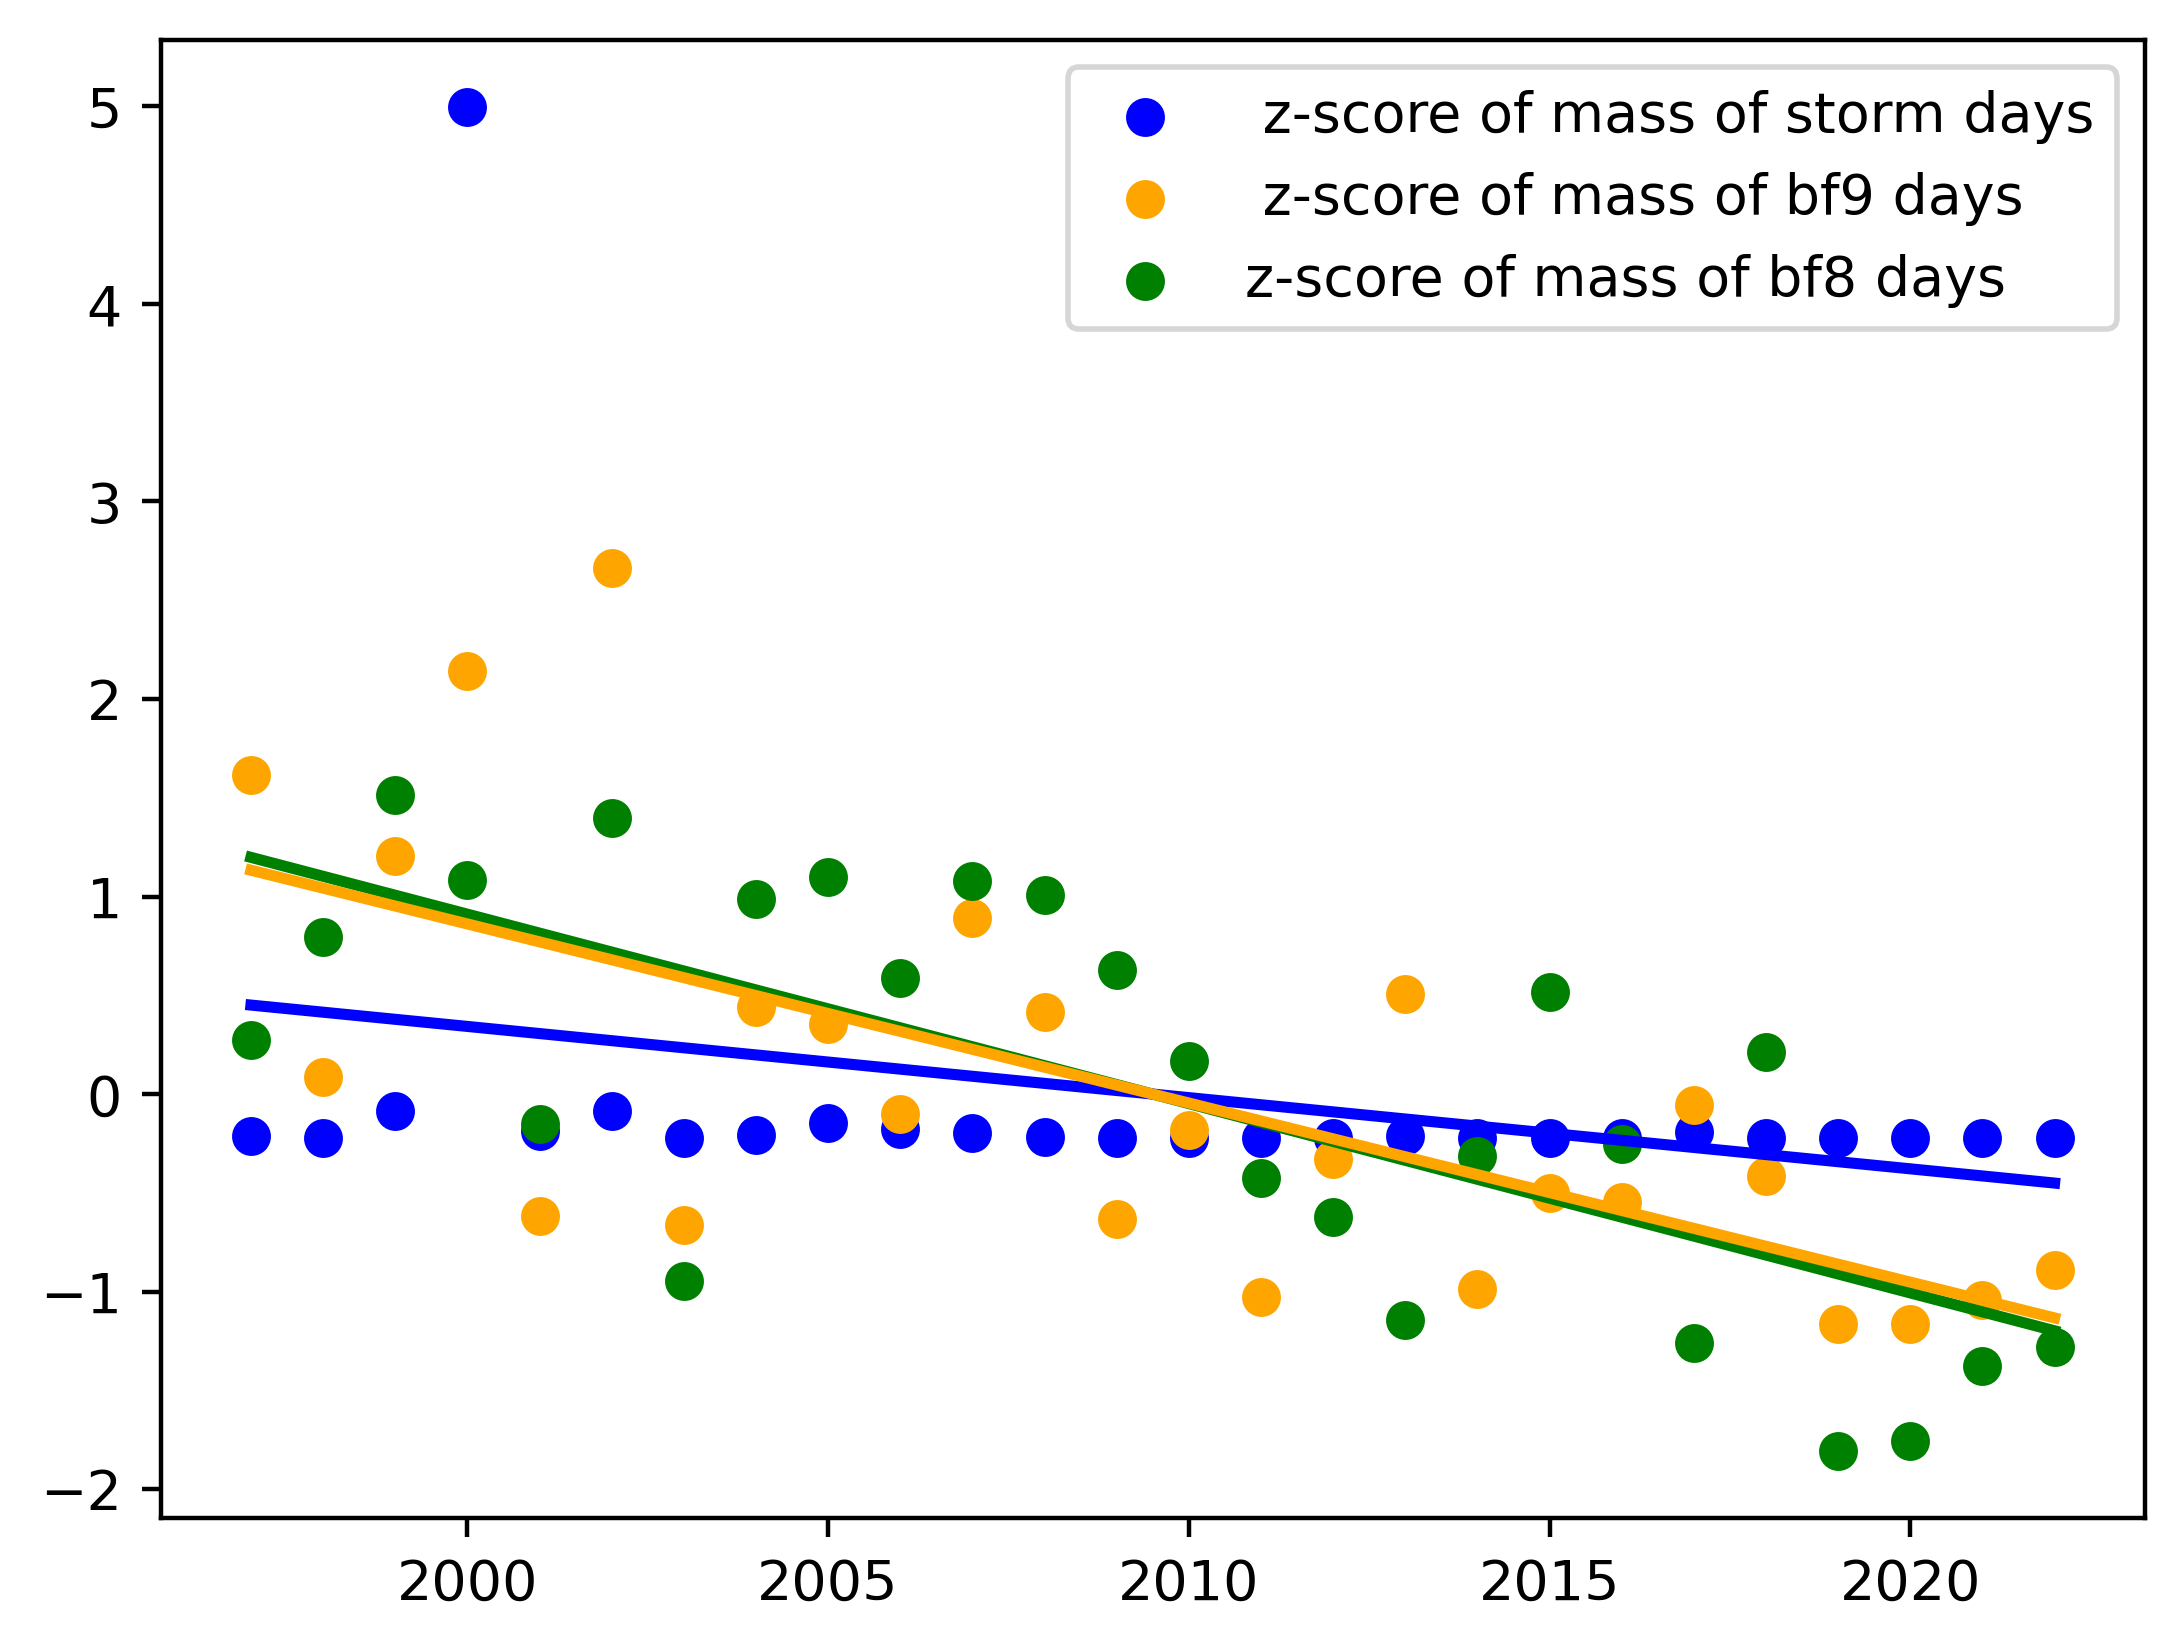

In [275]:
#plot the mass of the different wind categories, accounting for duration and speed:

mass_of_storms=dict()
mass_of_bf9=dict()
mass_of_bf8=dict()

for i in storm_df.index:
    if storm_df.loc[i, "MESS_DATUM"].year not in mass_of_storms:
       mass_of_storms[storm_df.loc[i, "MESS_DATUM"].year]=0
    else:
        mass_of_storms[storm_df.loc[i, "MESS_DATUM"].year]+=storm_df.loc[i,"FF_10_wind"]


for i in bf9_df.index:
    if bf9_df.loc[i, "MESS_DATUM"].year not in mass_of_bf9:
        mass_of_bf9[bf9_df.loc[i, "MESS_DATUM"].year]=0
    else:
        mass_of_bf9[bf9_df.loc[i, "MESS_DATUM"].year]+= bf9_df.loc[i,"FF_10_wind"]


for i in bf8_df.index:
    if bf8_df.loc[i, "MESS_DATUM"].year not in mass_of_bf8:
        mass_of_bf8[bf8_df.loc[i, "MESS_DATUM"].year]=0
    else:
        mass_of_bf8[bf8_df.loc[i, "MESS_DATUM"].year]+=bf8_df.loc[i,"FF_10_wind"]

# turn dictionarys into arrays
mass_storm_arr= np.empty([1,0]) 
for i in range(0, len(xarr)):
   if xarr[i] in mass_of_storms:
        mass_storm_arr=np.append(mass_storm_arr, mass_of_storms[xarr[i]])
   else:
      mass_storm_arr=np.append(mass_storm_arr,0) 

mass_bf9_arr= np.empty([1,0])
for i in range(0, len(xarr)):
   if xarr[i] in number_of_bf9_days:
        mass_bf9_arr=np.append(mass_bf9_arr, mass_of_bf9[xarr[i]])
   else:
      mass_bf9_arr=np.append(mass_bf9_arr,0) 

mass_bf8_arr= np.empty([1,0])
for i in range(0, len(xarr)):
   if xarr[i] in number_of_bf8_days:
        mass_bf8_arr=np.append(mass_bf8_arr, mass_of_bf8[xarr[i]])
   else:
      mass_bf8_arr=np.append(mass_bf8_arr,0) 


# normalize
mass_bf9_arr=(mass_bf9_arr - np.mean(mass_bf9_arr))/np.std(mass_bf9_arr)
mass_bf8_arr=(mass_bf8_arr - np.mean(mass_bf8_arr))/np.std(mass_bf8_arr)
mass_storm_arr=(mass_storm_arr - np.mean(mass_storm_arr))/np.std(mass_storm_arr)


#polynomial regression and plotting
mass_bf9_pol=np.polyfit(xarr, mass_bf9_arr, 1)
mass_bf9_model = np.poly1d(mass_bf9_pol)

mass_bf8_pol=np.polyfit(xarr, mass_bf8_arr, 1)
mass_bf8_model = np.poly1d(mass_bf8_pol)

mass_storm_pol=np.polyfit(xarr, mass_storm_arr, 1)
mass_storm_model = np.poly1d(mass_storm_pol)


plt.scatter(xarr, mass_storm_arr, color='blue', label=' z-score of mass of storm days')
plt.scatter(xarr, mass_bf9_arr,  color='orange', label=' z-score of mass of bf9 days ')

plt.scatter(xarr, mass_bf8_arr,  color='green', label='z-score of mass of bf8 days ')
plt.plot(xarr, mass_bf8_model(xarr), color='green', linewidth = 2)
plt.plot(xarr, mass_storm_model(xarr), color='blue', linewidth = 2)
plt.plot(xarr, mass_bf9_model(xarr), color='orange', linewidth = 2)
plt.legend()
plt.show()





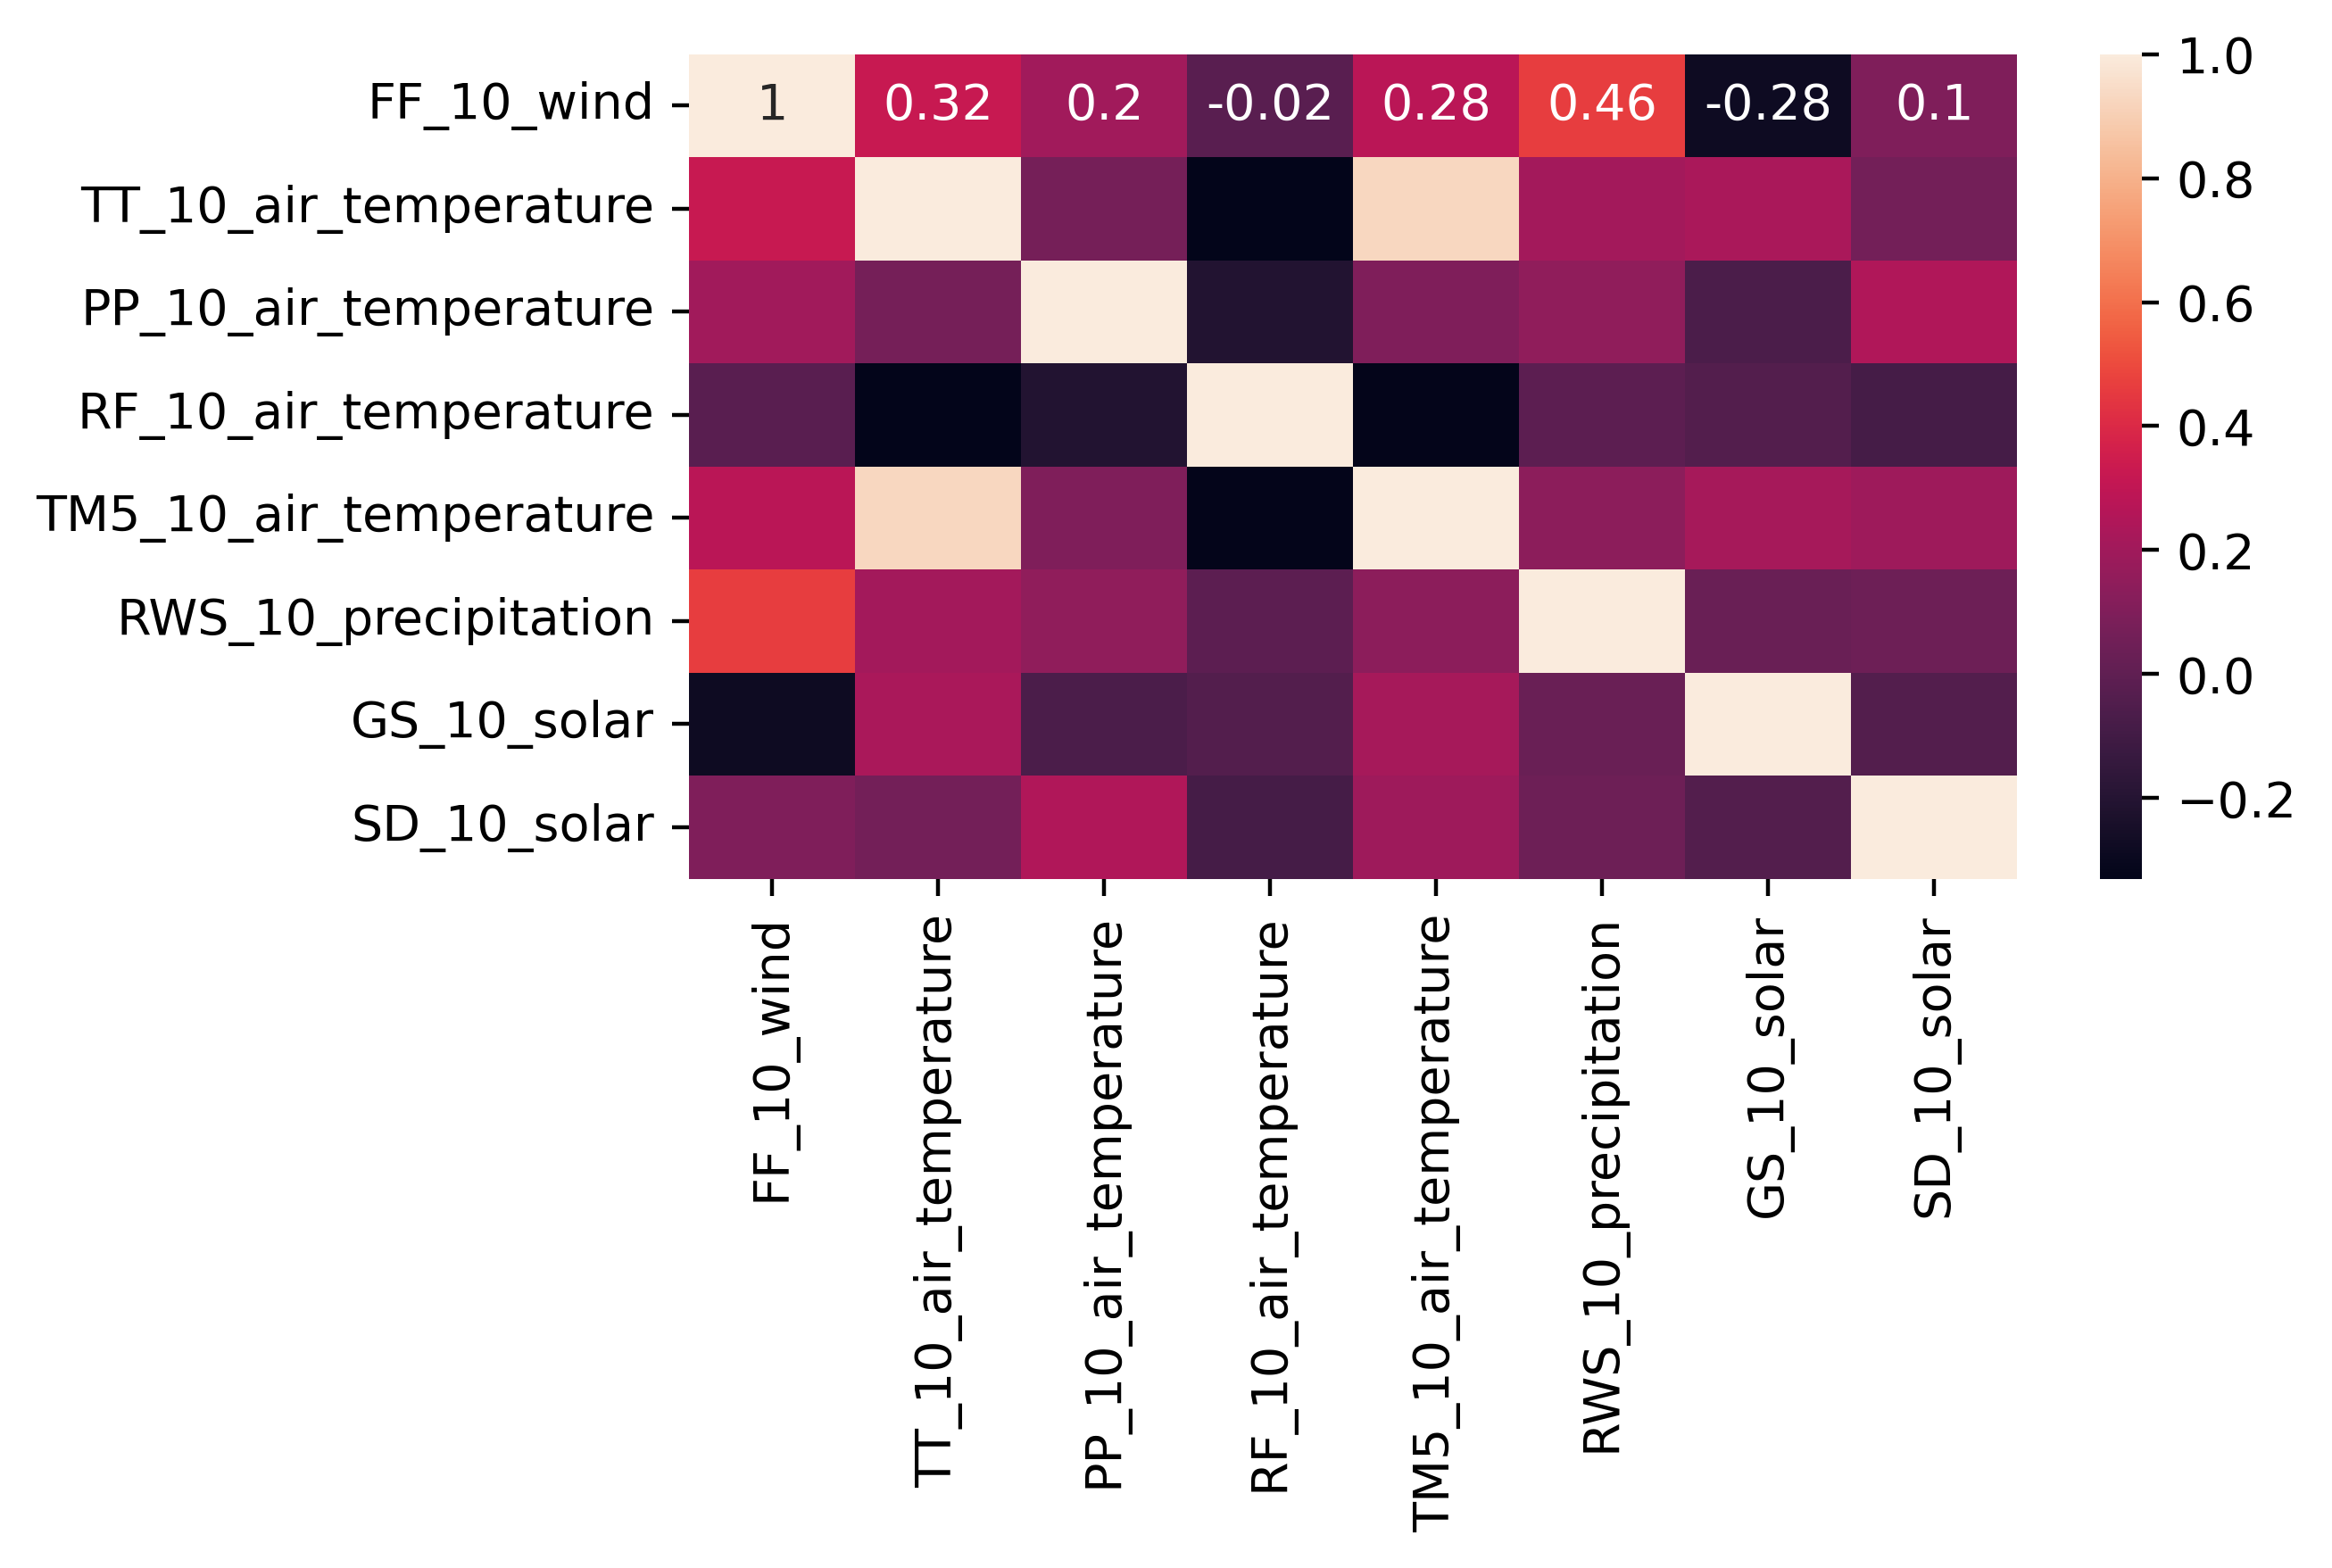

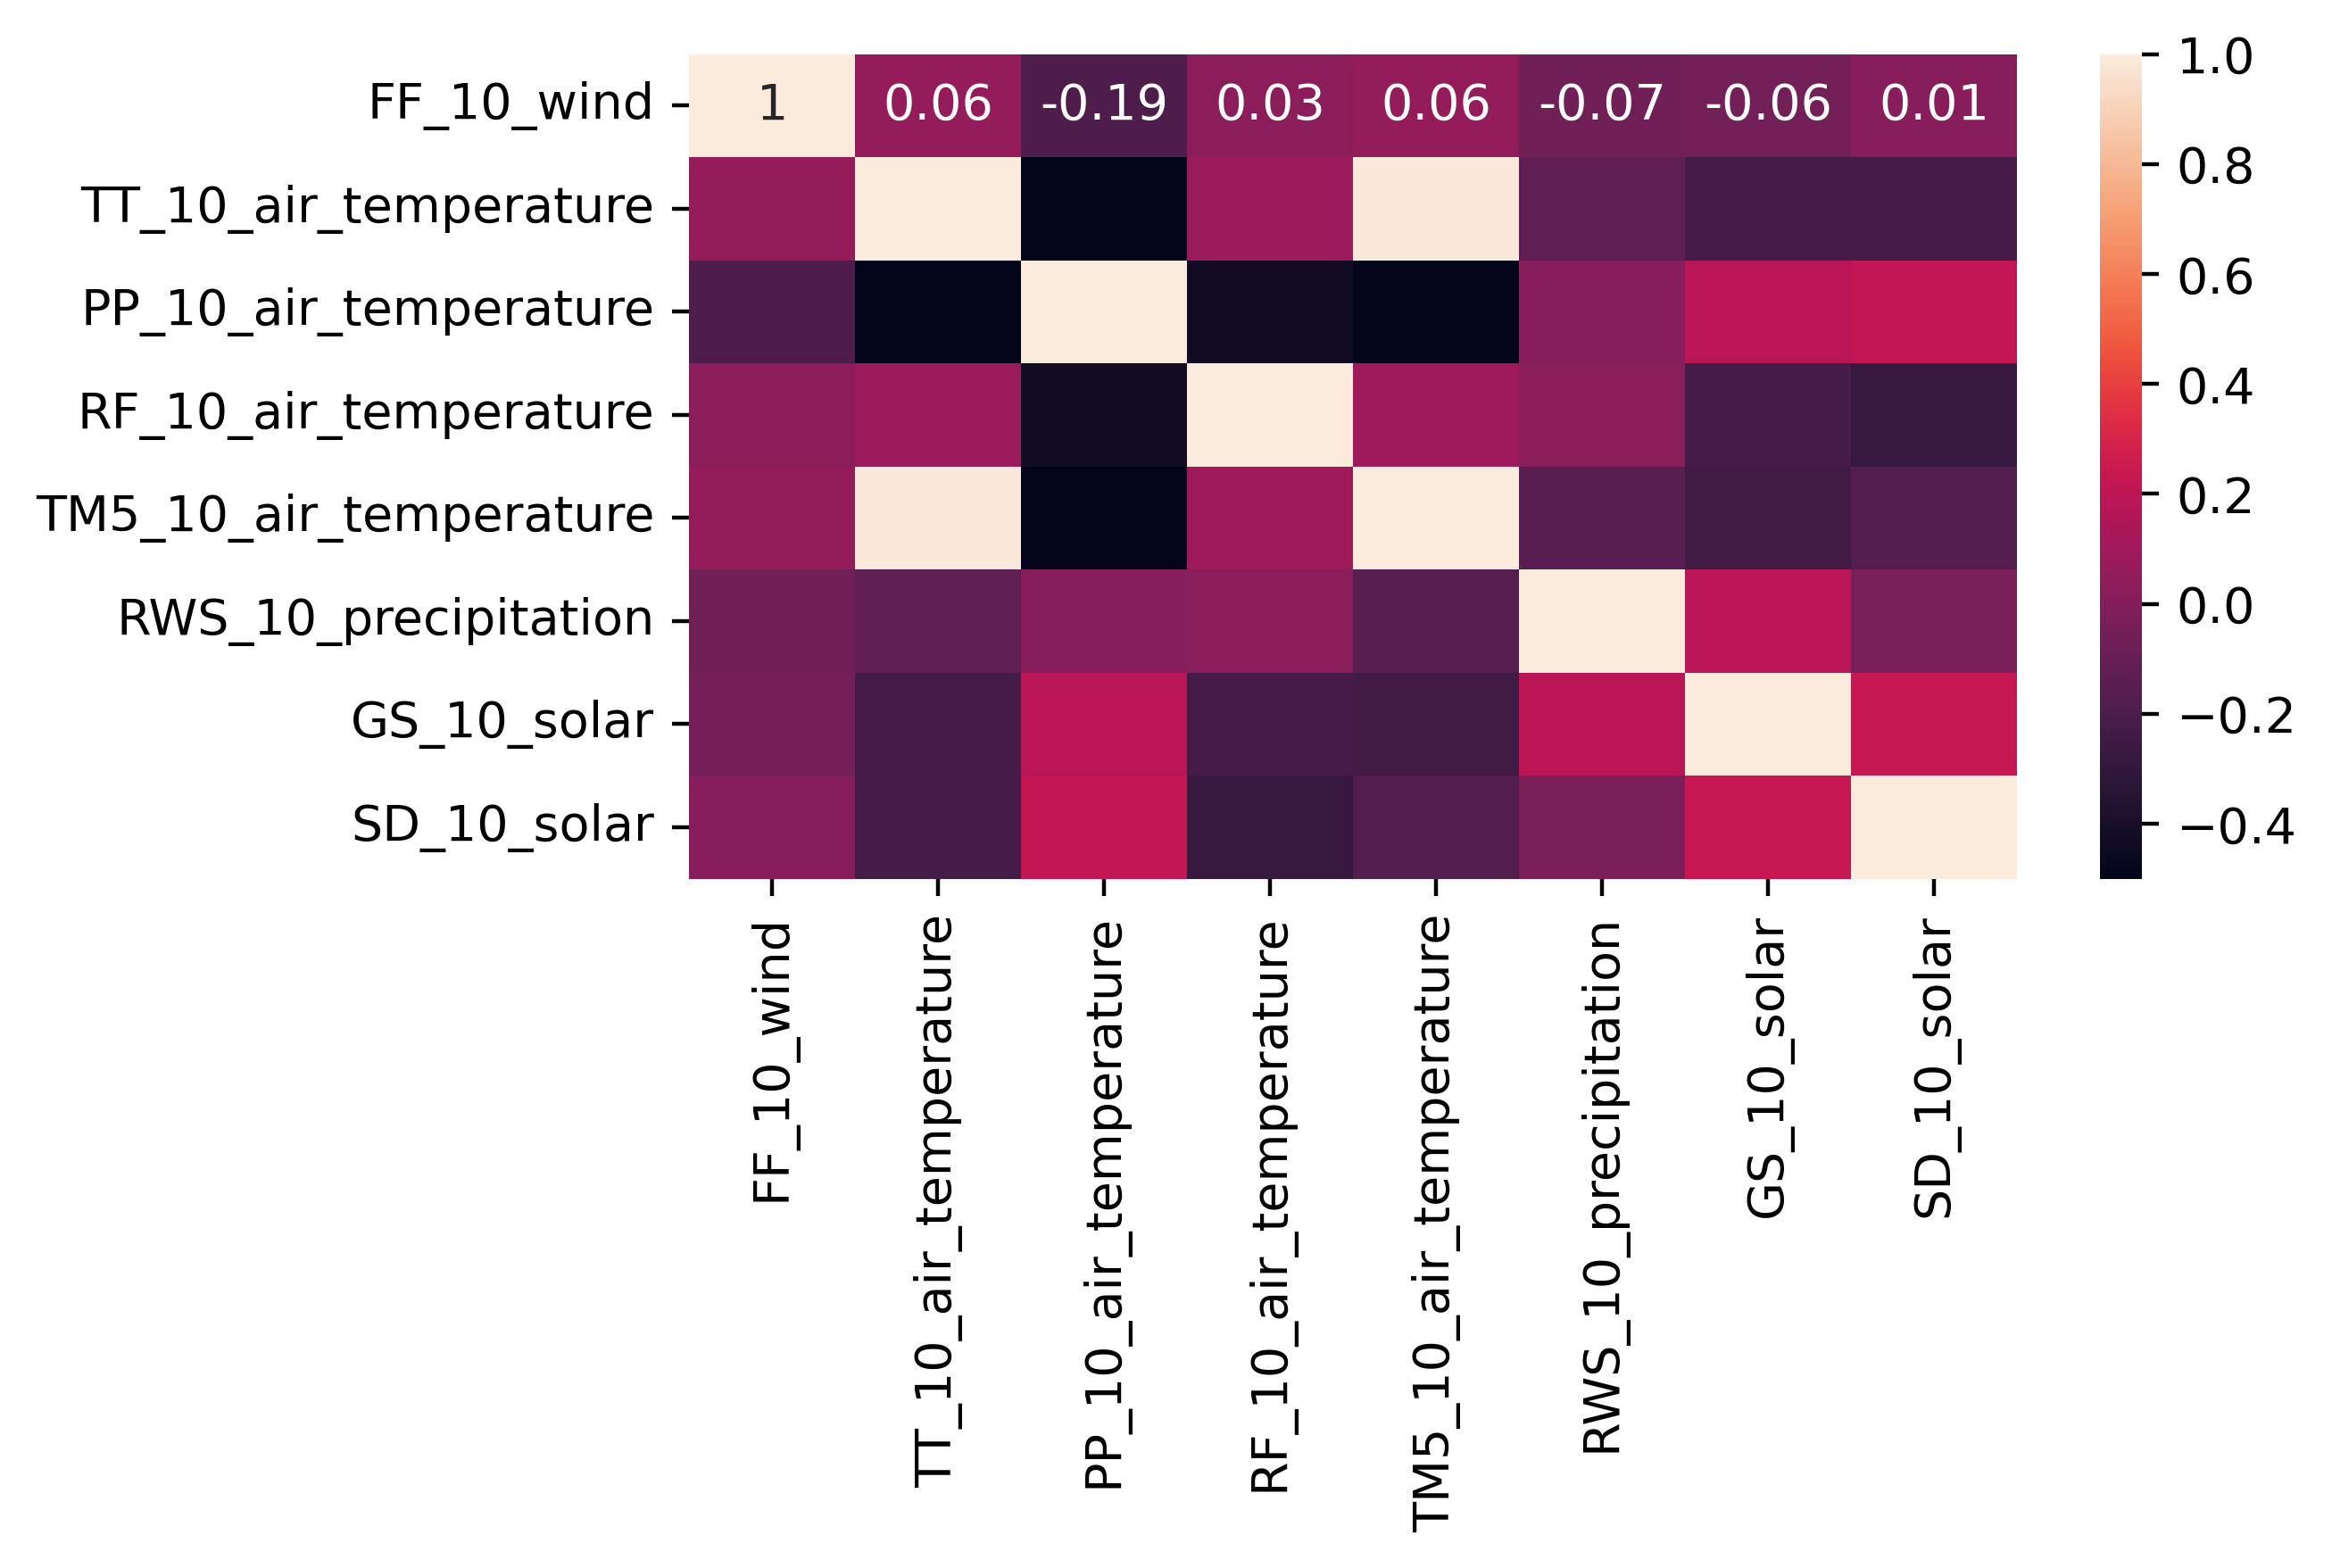

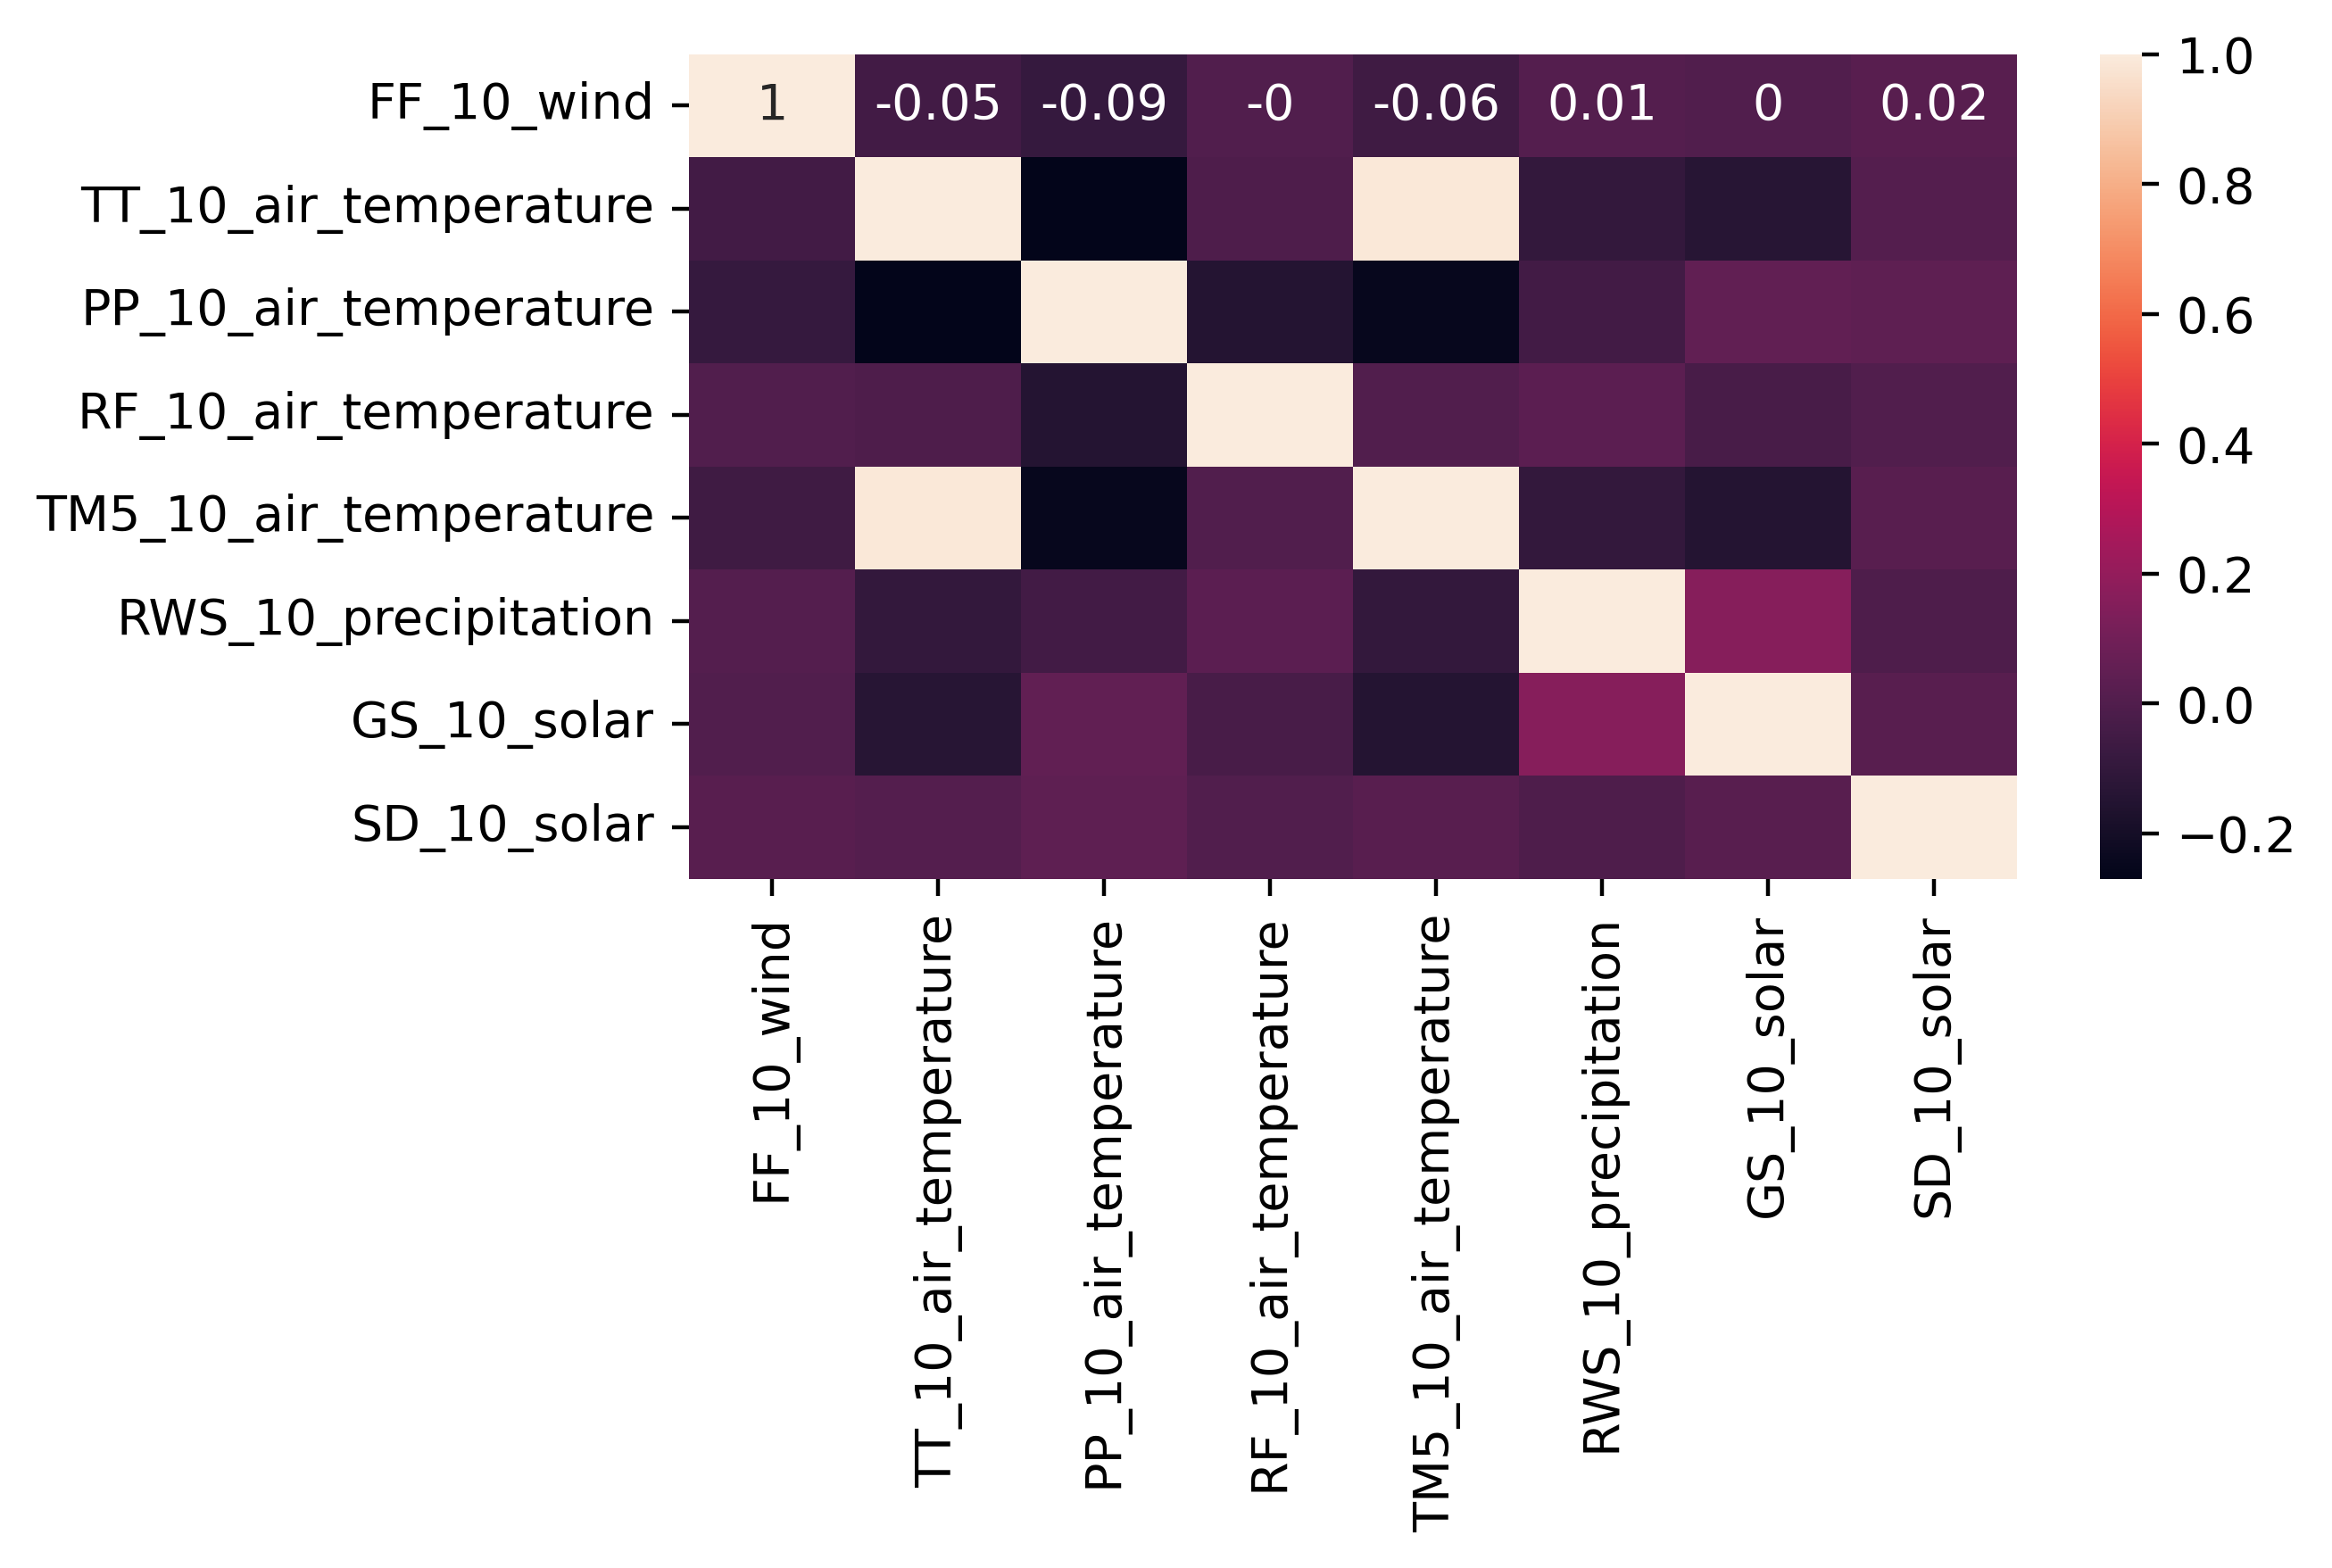

In [246]:
_ = plt.figure(figsize=(6, 3))
storm_corr_df = storm_df[["FF_10_wind", "TT_10_air_temperature", "PP_10_air_temperature", "RF_10_air_temperature", "TM5_10_air_temperature", "RWS_10_precipitation", "GS_10_solar", "SD_10_solar"]].corr().round(2)
sns.heatmap(storm_corr_df, annot=True)
plt.show()

_ = plt.figure(figsize=(6, 3))
bf9_corr_df = bf9_df[["FF_10_wind", "TT_10_air_temperature", "PP_10_air_temperature", "RF_10_air_temperature", "TM5_10_air_temperature", "RWS_10_precipitation", "GS_10_solar", "SD_10_solar"]].corr().round(2)
sns.heatmap(bf9_corr_df, annot=True)
plt.show()

_ = plt.figure(figsize=(6, 3))
bf8_corr_df = bf8_df[["FF_10_wind", "TT_10_air_temperature", "PP_10_air_temperature", "RF_10_air_temperature", "TM5_10_air_temperature", "RWS_10_precipitation", "GS_10_solar", "SD_10_solar"]].corr().round(2)
sns.heatmap(bf8_corr_df, annot=True)
plt.show()